In [1]:
using AgentBasedModels
using GLMakie
import GLMakie.GeometryBasics
using Random
using Distributions
using CUDA

using BenchmarkTools

# Fourth part of the model: Chemical interactions

## Electrophysiological dynamics

### Test 1: Dynamics of static cells in oscillating Ke environment

In [235]:
model = @agent(2,
    
            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            absorption::Local,
            tProp::Local,
            tMaxProp::Global,
            Ke::Local,          #Difussible medium
            cell::Identity,      #Biofilm cell 1, motile cell tumbling and propelling 2

            UpdateVariable = begin                                   #Equations of the chemical
                VK = VK0+δK*(absorption*Ke+Ki)                        #Resting potential
                VL = VL0+δL*(absorption*Ke+Ki)                        #Resting potential
                d(V) = (-gK*n^4*(V-VK)-gL*(V-VL))/(η*C)*dt           #Membrane potential
                d(n) = (α0*S^mc/(Sth^mc+S^mc)*(1-n)-βc*n)/η*dt       #Potasium levels
                d(S) = (αs*(Vth-V)/(exp((Vth-V)/σ)-1)-γs*S)/η*dt     #Stress
                d(Ki) = (-ϵ*gK*n^4*(V-VK)+βK*max((V0-V),0))*dt       #Intercellular potassium
                d(E) = (-αE*V-γE*E)*dt                               #Energy
            end,
    
            UpdateLocal = begin
                if cell == 1
                    tt = mod(ωPulse*t,2π)
                    if tt >= 0 && tt < π/2
                        Ke = 0
                    elseif tt < 4π/5
                        Ke = 10*αk/3/π*(tt-π/2)
                    elseif tt < 17π/10
                        Ke = αk*10/9/π*(9π/10-(tt-4π/5))
                    else
                        Ke = 0
                    end
                end
                
                P = KE^q/(abs((E-E0))^q+KE^q)        
            end,
)
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");

In [236]:
com = Community(compiled, N = 5, mediumN = [11,11])

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 10; mA = 1; mS = mA/mV;
com.gK = 36/10E12*μm^2/mS
com.gL = 0.3/10E12*μm^2/mS
com.C = 1*10E-3/10E12*μm^2/mF
com.VK0 = -688/mV
com.VL0 = -5694/mV
com.δK = 1*mM/mV
com.δL = 18*mM/mV
com.Sth = 0.04/mM
com.Vth = -148/mV
com.α0 = 0.12*ms
com.βc = 0.156*ms
com.mc = 1
com.σ = 0.2/mV
com.γs = 0.3*ms
com.αs = 0.03*ms*mV/mM
com.η = 300
com.ϵ = 7000*10E12/3600*mA*ms/mM/μm^2
com.βK = 0.8/3600*ms*mV/mM
com.V0 = -148/mV
com.αE = 0.008/3600*ms*mV
com.γE = 0.8/3600*ms
com.E0 = 1.535/mM
com.q = 7
com.KE = 0.2/mM
com.αk = 47#64/3600*ms/mM*1000
com.βk = 400/3600*ms
com.Dk = 80000/3600*ms/μm^2
com.fProp = 0.
com.ωPulse = 1/2/216000*2*π*ms*120/200

println(com.global_)

#Local parameters
com.cell .= 1;
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.absorption .= range(0,1,length=com.N)

com.simulationBox .= [-1000 1000;-1000 1000]
com.radiusInteraction = 1

[3.6e-12, 3.0e-14, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 1.2, 1.56, 1.0, 0.2, 3.0, 0.3, 300.0, 1.9444444444444444e14, 0.0022222222222222222, -148.0, 2.222222222222222e-5, 0.0022222222222222222, 1.535, 7.0, 0.2, 47.0, 1.1111111111111112, 222.22222222222223, 0.0, 8.726646259971648e-5, 0.0]


1

In [237]:
compiled = compile(model,neighbors="full",integrator="Heun",save="RAM",platform="cpu");
@time comt = compiled.evolve(com, tMax = 80000, dt = 1, dtSave = 100);

  1.507016 seconds (5.06 M allocations: 349.780 MiB, 4.91% gc time, 38.24% compilation time)


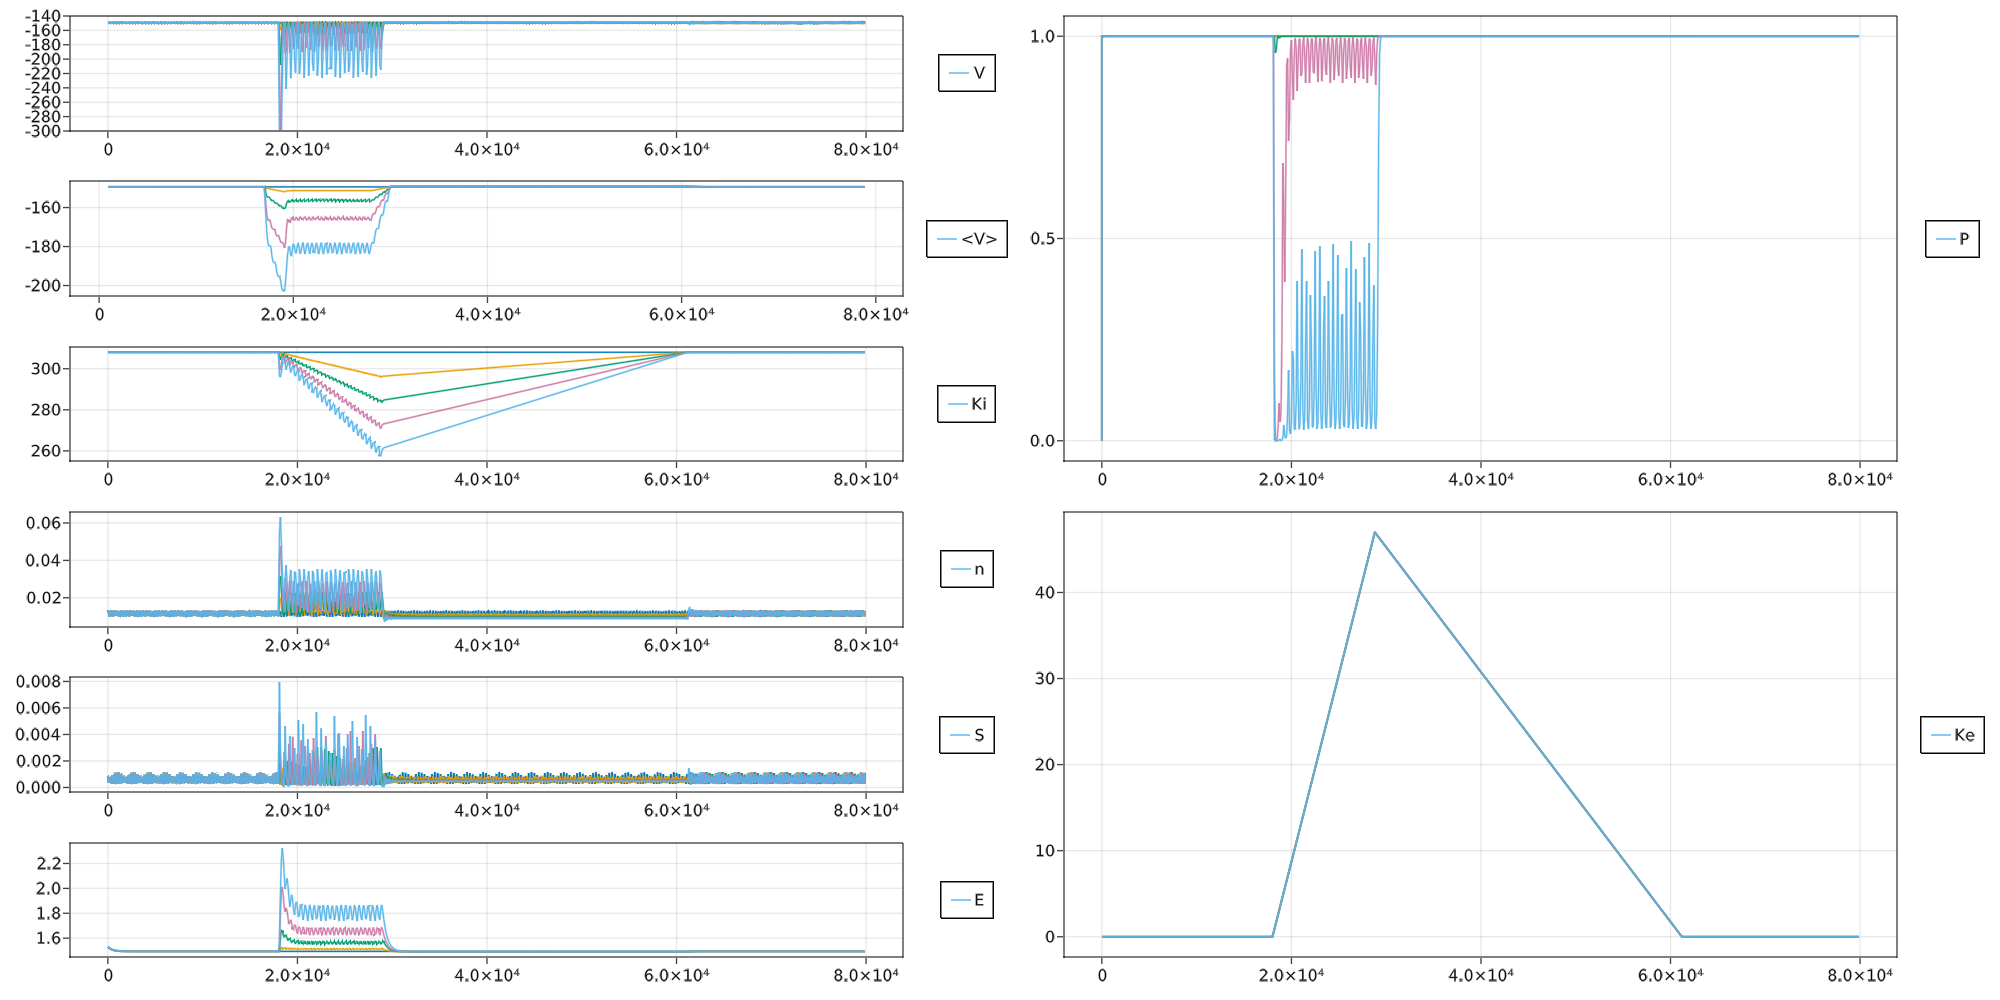

In [238]:
N0 = 1
N = length(comt)

fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.V[N0:N,i])
    Legend(fig[1,2],[l],["V"])
end
ylims!(ax,(-300,-140))

ax = Axis(fig[2,1])
av = 10
V = comt.V
for i in 1:com.N
    Vmean = [mean(V[j-av:j+av,i]) for j in N0+av:N-av]
    l = lines!(comt.t[N0+av:N-av],Vmean)
    Legend(fig[2,2],[l],["<V>"])
end

ax = Axis(fig[3,1])
for i in 1:com.N
    l = lines!(comt.t[N0:N],comt.Ki[N0:N,i])
    Legend(fig[3,2],[l],["Ki"])
end

ax = Axis(fig[4,1])
for i in 1:com.N
    l = lines!(comt.t[N0:N],comt.n[N0:N,i])
    Legend(fig[4,2],[l],["n"])
end

ax = Axis(fig[5,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.S[N0:N,i])
    Legend(fig[5,2],[l],["S"])
end

ax = Axis(fig[6,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.E[N0:N,i])
    Legend(fig[6,2],[l],["E"])
end

ax = Axis(fig[1:3,3])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.P[N0:N,i],label="P")
    Legend(fig[1:3,4],[l],["P"])
end

ax = Axis(fig[4:6,3])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.Ke[N0:N,i],label="Ke")
    Legend(fig[4:6,4],[l],["Ke"])
end

fig

### Test 2: Dynamics of static cells in static Ke environment

In [48]:
model = @agent(2,

            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            absorption::Local,
            tProp::Local,
            tMaxProp::Global,
            Ke::Local,          #Difussible medium
            cell::Identity,      #Biofilm cell 1, motile cell tumbling and propelling 2

            UpdateVariable = begin                                   #Equations of the chemical
                VK = VK0+δK*(absorption*Ke+Ki)                        #Resting potential
                VL = VL0+δL*(absorption*Ke+Ki)                        #Resting potential
                d(V) = (-gK*n^4*(V-VK)-gL*(V-VL))/(η*C)*dt           #Membrane potential
                d(n) = (α0*S^mc/(Sth^mc+S^mc)*(1-n)-βc*n)/η*dt       #Potasium levels
                d(S) = (αs*(Vth-V)/(exp((Vth-V)/σ)-1)-γs*S)/η*dt     #Stress
                d(Ki) = (-ϵ*gK*n^4*(V-VK)+βK*max((V0-V),0))*dt       #Intercellular potassium
                d(E) = (-αE*V-γE*E)*dt                               #Energy
            end,
    
            UpdateLocal = begin
                if cell == 1
                    Ke = min(.01*t,αk)
                end
                
                P = KE^q/(abs((E-E0))^q+KE^q)         
            end,
    
)
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");

In [49]:
com = Community(compiled, N = 5, mediumN = [11,11])

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 10; mA = 1; mS = mA/mV;
com.gK = 36/10E12*μm^2/mS
com.gL = 0.3/10E12*μm^2/mS
com.C = 1*10E-3/10E12*μm^2/mF
com.VK0 = -688/mV
com.VL0 = -5694/mV
com.δK = 1*mM/mV
com.δL = 18*mM/mV
com.Sth = 0.04/mM
com.Vth = -148/mV
com.α0 = 0.12*ms
com.βc = 0.156*ms
com.mc = 1
com.σ = 0.2/mV
com.γs = 0.3*ms
com.αs = 0.03*ms*mV/mM
com.η = 300
com.ϵ = 7000*10E12/3600*mA*ms/mM/μm^2
com.βK = 0.8/3600*ms*mV/mM
com.V0 = -148/mV
com.αE = 0.008/3600*ms*mV
com.γE = 0.8/3600*ms
com.E0 = 1.535/mM
com.q = 7
com.KE = 0.2/mM
com.αk = 47#64/3600*ms/mM*1000
com.βk = 400/3600*ms
com.Dk = 80000/3600*ms/μm^2
com.fProp = 0.
com.ωPulse = 1/2/216000*2*π*ms*120/200

println(com.global_)

#Local parameters
com.cell .= 1;
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.absorption .= range(0,1,length=com.N)

com.simulationBox .= [-1000 1000;-1000 1000]
com.radiusInteraction = 1

[3.6e-12, 3.0e-14, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 1.2, 1.56, 1.0, 0.2, 3.0, 0.3, 300.0, 1.9444444444444444e14, 0.0022222222222222222, -148.0, 2.222222222222222e-5, 0.0022222222222222222, 1.535, 7.0, 0.2, 47.0, 1.1111111111111112, 222.22222222222223, 0.0, 8.726646259971648e-5, 0.0]


1

In [50]:
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");
@time comt = compiled.evolve(com, tMax = 80000, dt = 1, dtSave = 100);

  1.098266 seconds (4.70 M allocations: 304.406 MiB, 4.03% gc time, 39.33% compilation time)


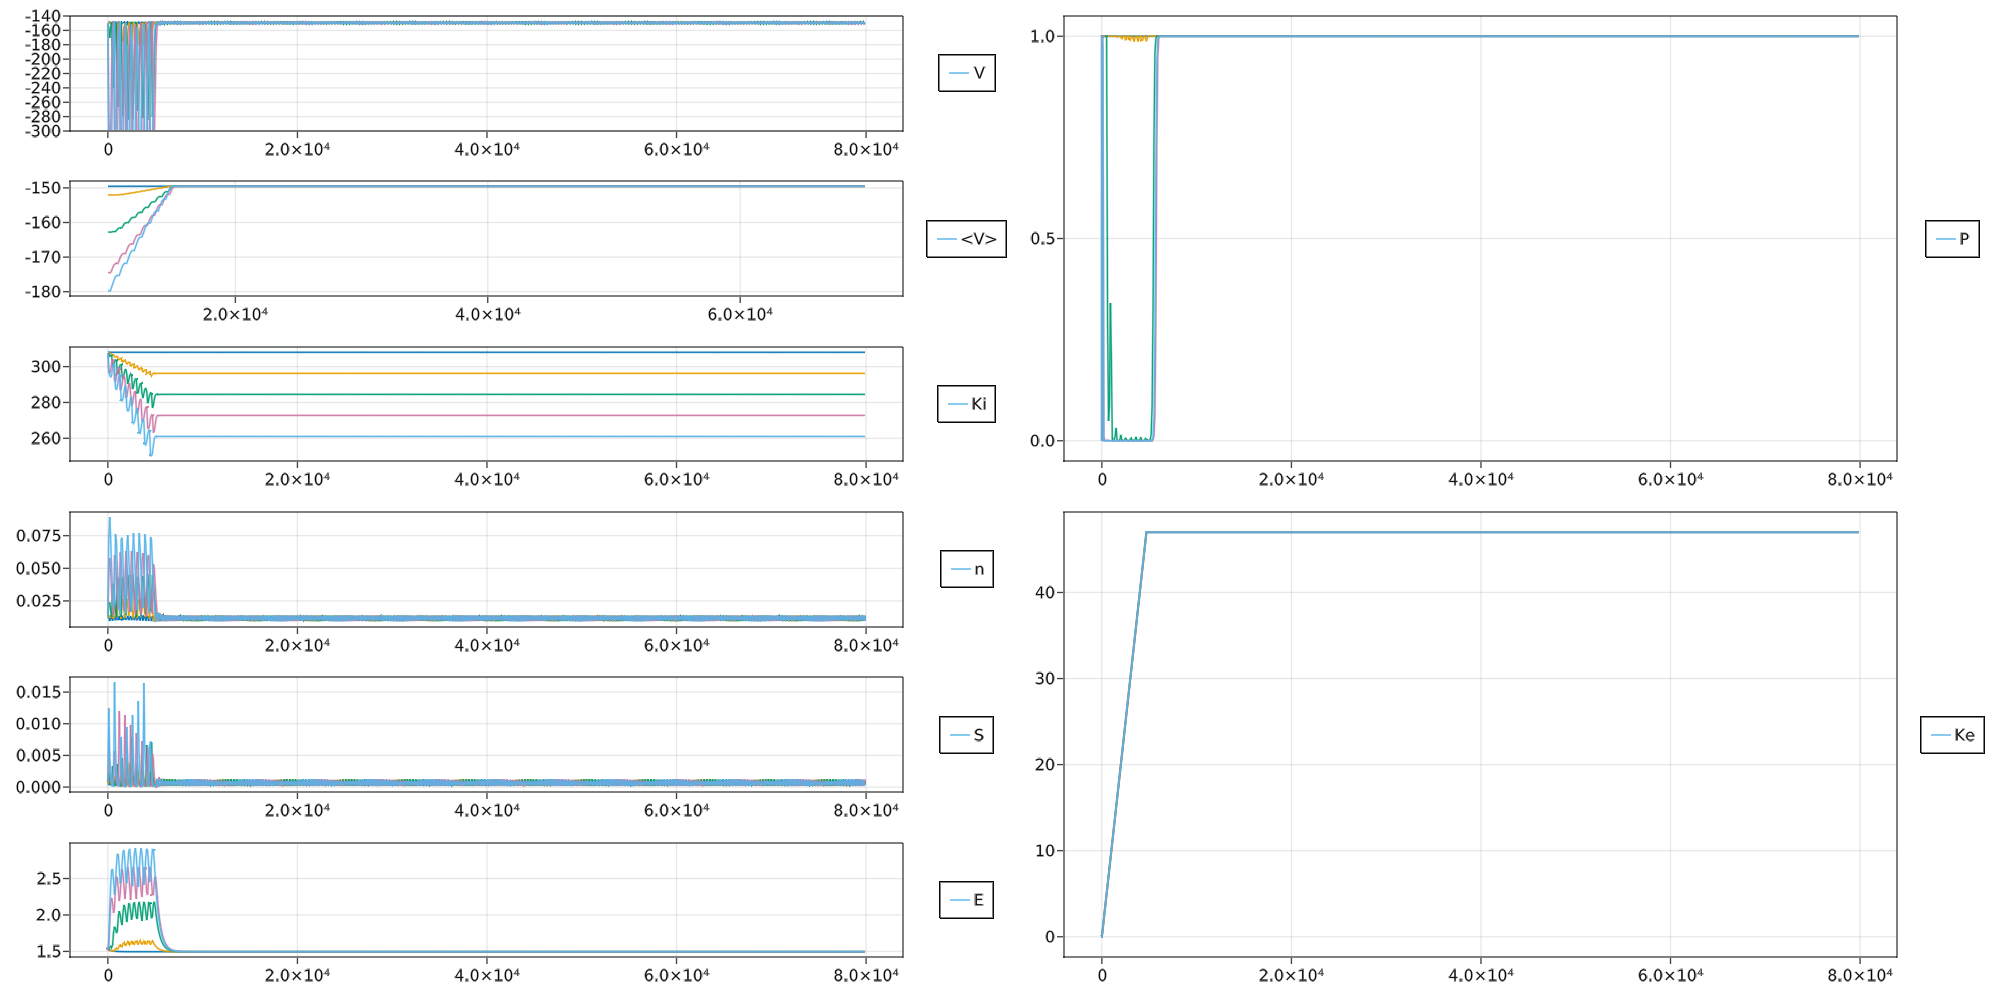

In [51]:
N0 = 1
N = length(comt)

fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.V[N0:N,i])
    Legend(fig[1,2],[l],["V"])
end
ylims!(ax,(-300,-140))

ax = Axis(fig[2,1])
av = 100
V = comt.V
for i in 1:com.N
    Vmean = [mean(V[j-av:j+av,i]) for j in N0+av:N-av]
    l = lines!(comt.t[N0+av:N-av],Vmean)
    Legend(fig[2,2],[l],["<V>"])
end

ax = Axis(fig[3,1])
for i in 1:com.N
    l = lines!(comt.t[N0:N],comt.Ki[N0:N,i])
    Legend(fig[3,2],[l],["Ki"])
end

ax = Axis(fig[4,1])
for i in 1:com.N
    l = lines!(comt.t[N0:N],comt.n[N0:N,i])
    Legend(fig[4,2],[l],["n"])
end

ax = Axis(fig[5,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.S[N0:N,i])
    Legend(fig[5,2],[l],["S"])
end

ax = Axis(fig[6,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.E[N0:N,i])
    Legend(fig[6,2],[l],["E"])
end

ax = Axis(fig[1:3,3])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.P[N0:N,i],label="P")
    Legend(fig[1:3,4],[l],["P"])
end

ax = Axis(fig[4:6,3])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.Ke[N0:N,i],label="Ke")
    Legend(fig[4:6,4],[l],["Ke"])
end

fig

## Motility of cells in artificial gradient

### Test 1: Tumbling frequency of motile cells ascending static gradient of Ke

In [37]:
model = @agent(2,
    
            theta::Local,
        
            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            absorption::Local,
            tProp::Local,
            Ke::Local,          # Difussible medium
            cell::Identity,      # Biofilm cell 1, motile cell tumbling and propelling 2

            UpdateVariable = begin                                   #Equations of the chemical
                VK = VK0+δK*(absorption*Ke+Ki)                       #Resting potential
                VL = VL0+δL*(absorption*Ke+Ki)                       #Resting potential
                d(V) = (-gK*n^4*(V-VK)-gL*(V-VL))/(η*C)*dt           #Membrane potential
                d(n) = (α0*S^mc/(Sth^mc+S^mc)*(1-n)-βc*n)/η*dt       #Potasium levels
                d(S) = (αs*(Vth-V)/(exp((Vth-V)/σ)-1)-γs*S)/η*dt     #Stress
                d(Ki) = (-ϵ*gK*n^4*(V-VK)+βK*max((V0-V),0))*dt       #Intercellular potassium
                d(E) = (-αE*V-γE*E)*dt                               #Energy
        
                if x < simulationBox[1,2]-.5
                    d(x) = fProp*dt
                end
            end,
    
            UpdateLocal = begin
                if cell == 2
                    Ke = αk*(x-simulationBox[1,1])/(simulationBox[1,2]-simulationBox[1,1])
                end
        
                #Boundaries to avoid scaping the box
                if x.new < simulationBox[1,1]
                    x = simulationBox[1,1]
                    theta = Uniform(-π/2,π/2) 
                end
                if x.new > simulationBox[1,2]
                    x = simulationBox[1,2]
                    theta = Uniform(π/2,3π/2) 
                end
                if y.new < simulationBox[2,1]
                    y = simulationBox[2,1]
                    theta = Uniform(0,π) 
                end
                if y.new > simulationBox[2,2]
                    y = simulationBox[2,2]
                    theta = Uniform(-π,0) 
                end
        
                P = KE^q/(abs((E-E0))^q+KE^q)  
            end,
    
)
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");

In [38]:
com = Community(compiled, N = 1, mediumN = [11,11])

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 10; mA = 1; mS = mA/mV;
com.gK = 36/10E12*μm^2/mS
com.gL = 0.3/10E12*μm^2/mS
com.C = 1*10E-3/10E12*μm^2/mF
com.VK0 = -688/mV
com.VL0 = -5694/mV
com.δK = 1*mM/mV
com.δL = 18*mM/mV
com.Sth = 0.04/mM
com.Vth = -148/mV
com.α0 = 0.12*ms
com.βc = 0.156*ms
com.mc = 1
com.σ = 0.2/mV
com.γs = 0.3*ms
com.αs = 0.03*ms*mV/mM
com.η = 300
com.ϵ = 7000*10E12/3600*mA*ms/mM/μm^2
com.βK = 0.8/3600*ms*mV/mM
com.V0 = -148/mV
com.αE = 0.008/3600*ms*mV
com.γE = 0.8/3600*ms
com.E0 = 1.535/mM
com.q = 7
com.KE = 0.2/mM
com.αk = 47#64/3600*ms/mM*1000
com.βk = 400/3600*ms
com.Dk = 80000/3600*ms/μm^2
com.fProp = 0.002*ms^2/μm
com.ωPulse = 1/2/216000*2*π*ms*120/200

println(com.global_)

#Local parameters
com.cell .= 2;
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.absorption .= 1

com.simulationBox .= [-400 100;-100 100]
com.radiusInteraction = 1

com.x .= com.simulationBox[1,1]

[3.6e-12, 3.0e-14, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 1.2, 1.56, 1.0, 0.2, 3.0, 0.3, 300.0, 1.9444444444444444e14, 0.0022222222222222222, -148.0, 2.222222222222222e-5, 0.0022222222222222222, 1.535, 7.0, 0.2, 47.0, 1.1111111111111112, 222.22222222222223, 0.2, 8.726646259971648e-5]


1-element view(::Matrix{Float64}, :, 1) with eltype Float64:
 -400.0

In [39]:
compiled = compile(model,neighbors="full",integrator="Heun",save="RAM",platform="cpu");
@time comt = compiled.evolve(com, tMax = 80000, dt = 1, dtSave = 1);

  1.784958 seconds (7.23 M allocations: 521.505 MiB, 3.91% gc time, 31.04% compilation time)


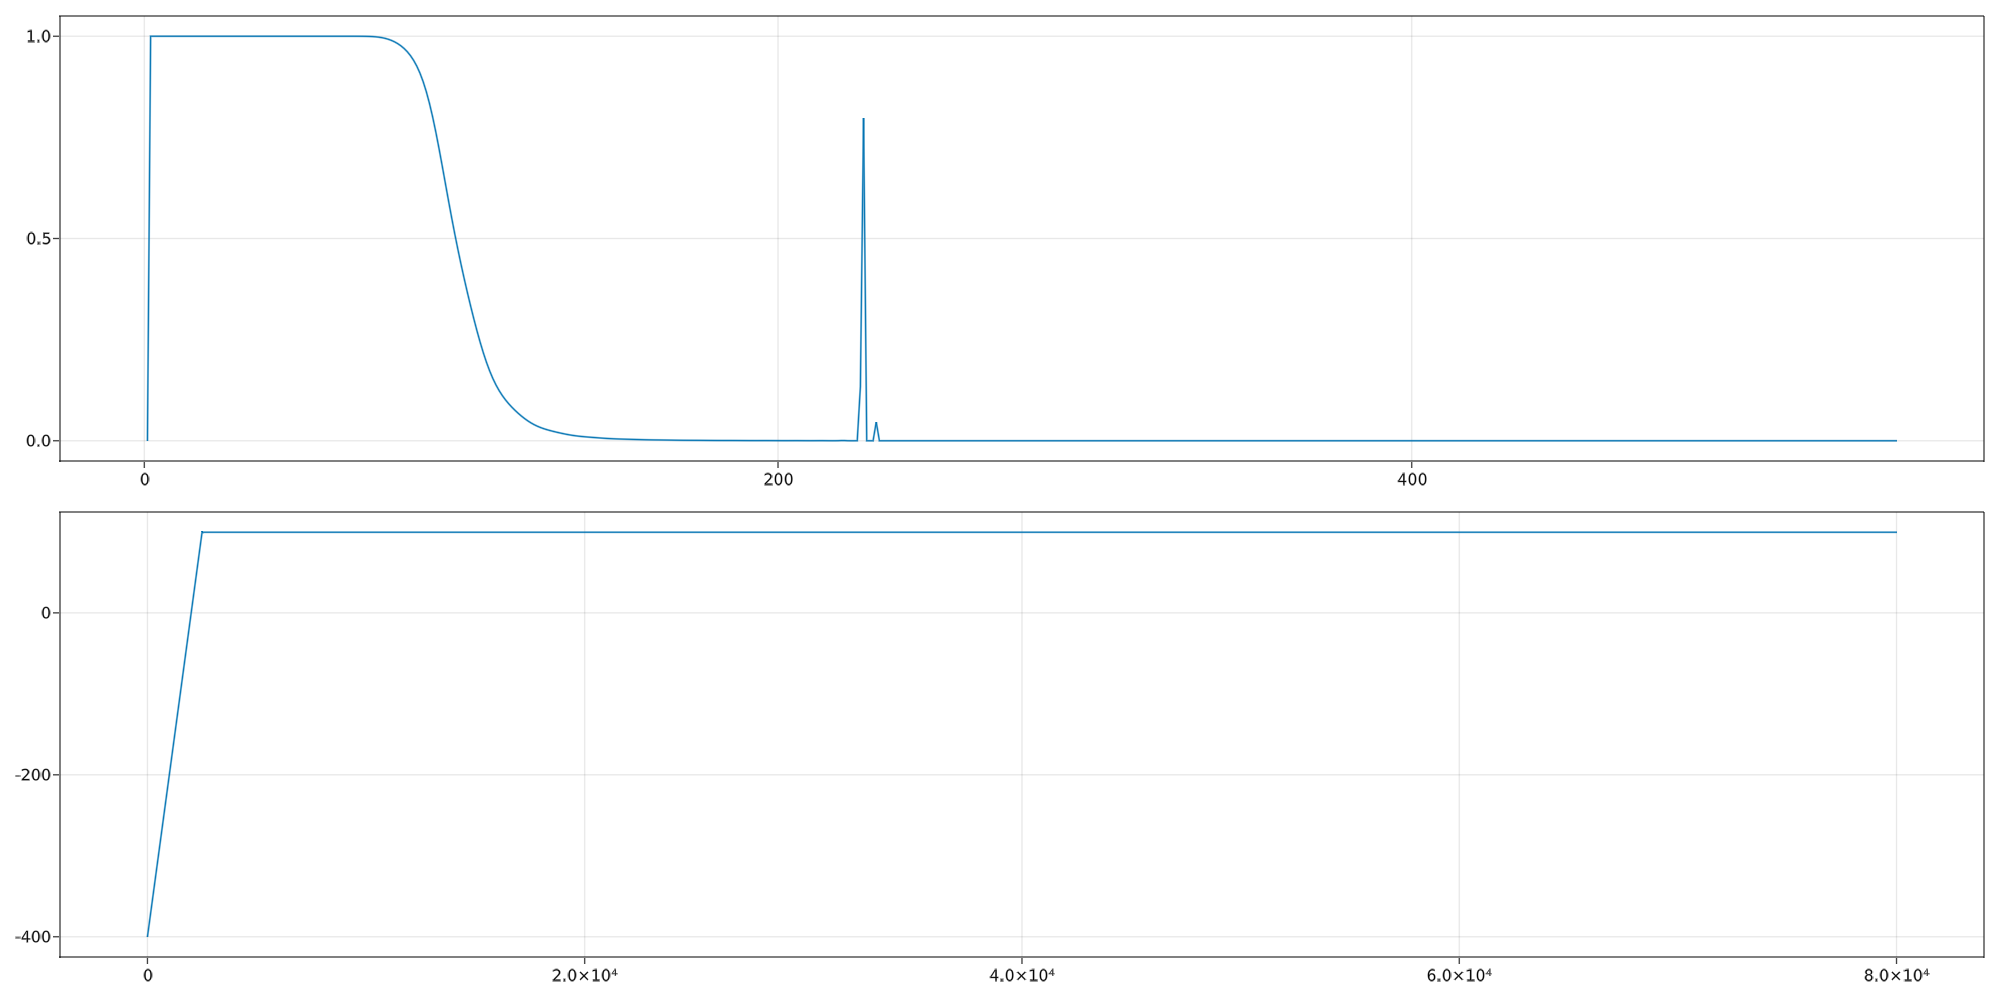

In [40]:
fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1])
x = comt.P
lines!(ax,1:length(comt),x[:,1])

ax = Axis(fig[2,1])
x = comt.x
lines!(ax,1:length(comt),x[:,1])

fig

### Test 2: Tumbling frequency of motile cells descending static gradient of Ke

In [41]:
model = @agent(2,
    
            theta::Local,
        
            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            absorption::Local,
            tProp::Local,
            Ke::Local,          # Difussible medium
            cell::Identity,      # Biofilm cell 1, motile cell tumbling and propelling 2

            UpdateVariable = begin                                   #Equations of the chemical
                VK = VK0+δK*(absorption*Ke+Ki)                       #Resting potential
                VL = VL0+δL*(absorption*Ke+Ki)                       #Resting potential
                d(V) = (-gK*n^4*(V-VK)-gL*(V-VL))/(η*C)*dt           #Membrane potential
                d(n) = (α0*S^mc/(Sth^mc+S^mc)*(1-n)-βc*n)/η*dt       #Potasium levels
                d(S) = (αs*(Vth-V)/(exp((Vth-V)/σ)-1)-γs*S)/η*dt     #Stress
                d(Ki) = (-ϵ*gK*n^4*(V-VK)+βK*max((V0-V),0))*dt       #Intercellular potassium
                d(E) = (-αE*V-γE*E)*dt                               #Energy
        
                d(x) = -fProp*dt
            end,
    
            UpdateLocal = begin
                if cell == 2
                    Ke = αk*(x-simulationBox[1,1])/(simulationBox[1,2]-simulationBox[1,1])
                end
        
                #Boundaries to avoid scaping the box
                if x.new < simulationBox[1,1]
                    x = simulationBox[1,1]
                    theta = Uniform(-π/2,π/2) 
                end
                if x.new > simulationBox[1,2]
                    x = simulationBox[1,2]
                    theta = Uniform(π/2,3π/2) 
                end
                if y.new < simulationBox[2,1]
                    y = simulationBox[2,1]
                    theta = Uniform(0,π) 
                end
                if y.new > simulationBox[2,2]
                    y = simulationBox[2,2]
                    theta = Uniform(-π,0) 
                end
        
                P = KE^q/(abs((E-E0))^q+KE^q)  
            end,
    
)
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");

In [42]:
com = Community(compiled, N = 1, mediumN = [11,11])

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 10; mA = 1; mS = mA/mV;
com.gK = 36/10E12*μm^2/mS
com.gL = 0.3/10E12*μm^2/mS
com.C = 1*10E-3/10E12*μm^2/mF
com.VK0 = -688/mV
com.VL0 = -5694/mV
com.δK = 1*mM/mV
com.δL = 18*mM/mV
com.Sth = 0.04/mM
com.Vth = -148/mV
com.α0 = 0.12*ms
com.βc = 0.156*ms
com.mc = 1
com.σ = 0.2/mV
com.γs = 0.3*ms
com.αs = 0.03*ms*mV/mM
com.η = 300
com.ϵ = 7000*10E12/3600*mA*ms/mM/μm^2
com.βK = 0.8/3600*ms*mV/mM
com.V0 = -148/mV
com.αE = 0.008/3600*ms*mV
com.γE = 0.8/3600*ms
com.E0 = 1.535/mM
com.q = 7
com.KE = 0.2/mM
com.αk = 47#64/3600*ms/mM*1000
com.βk = 400/3600*ms
com.Dk = 80000/3600*ms/μm^2
com.fProp = 0.0002*ms^2/μm
com.ωPulse = 1/2/216000*2*π*ms*120/200

println(com.global_)

#Local parameters
com.cell .= 2;
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.absorption .= 1

com.simulationBox .= [-400 100;-100 100]
com.radiusInteraction = 1

com.x .= com.simulationBox[1,2];

[3.6e-12, 3.0e-14, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 1.2, 1.56, 1.0, 0.2, 3.0, 0.3, 300.0, 1.9444444444444444e14, 0.0022222222222222222, -148.0, 2.222222222222222e-5, 0.0022222222222222222, 1.535, 7.0, 0.2, 47.0, 1.1111111111111112, 222.22222222222223, 0.02, 8.726646259971648e-5]


In [43]:
compiled = compile(model,neighbors="full",integrator="Heun",save="RAM",platform="cpu");
@time comt = compiled.evolve(com, tMax = 80000, dt = .1, dtSave = 1);

  8.080398 seconds (34.18 M allocations: 2.512 GiB, 4.85% gc time, 7.12% compilation time)


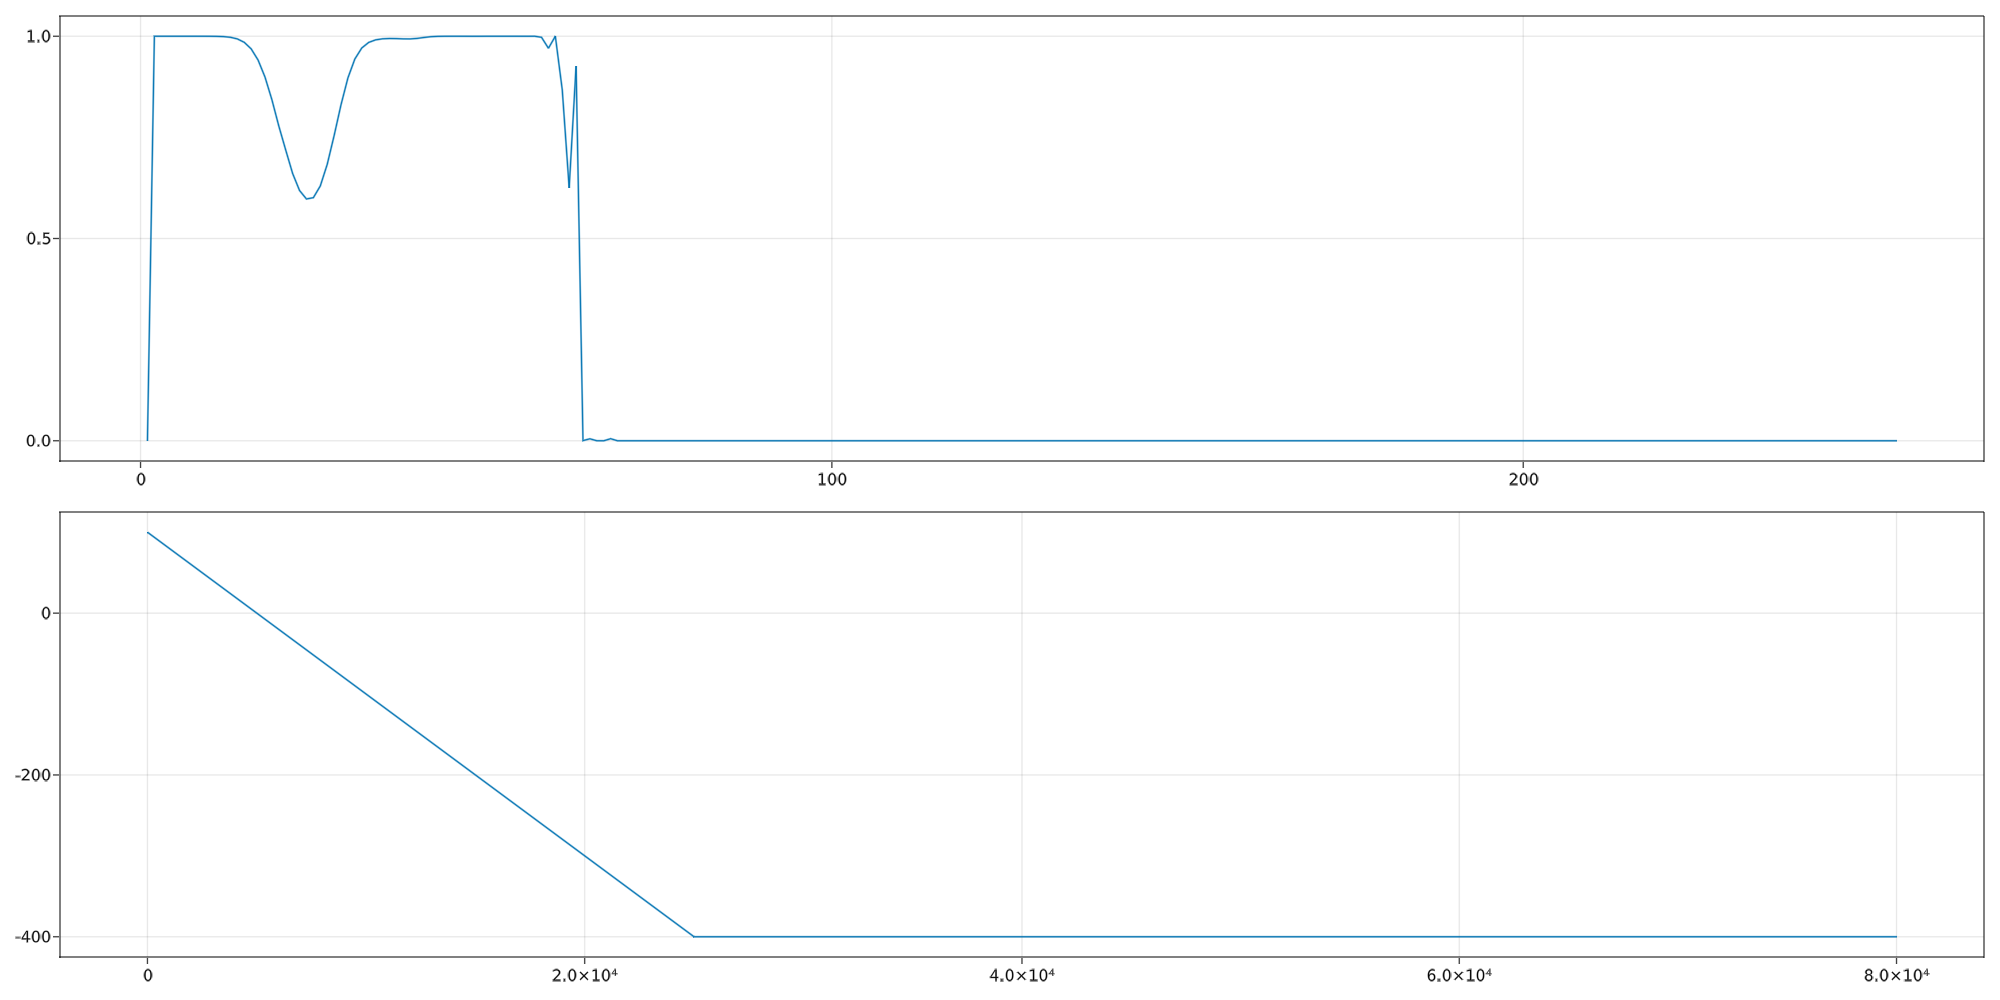

In [44]:
fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1])
x = comt.P
lines!(ax,1:length(comt),x[:,1])

ax = Axis(fig[2,1])
x = comt.x
lines!(ax,1:length(comt),x[:,1])

fig

### Test 3: Tumbling dynamics of motile cells in static gradient Ke environment

In [64]:
model = @agent(2,
    
            theta::Local,
        
            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            absorption::Local,
            tProp::Local,
            [tPersistence,tTumbling,tTumblingMin]::Global,
            KeWidth::Global,
            Ke::Local,          # Difussible medium
            cell::Identity,      # Biofilm cell 1, motile cell tumbling and propelling 2

            UpdateVariable = begin                                   #Equations of the chemical
                VK = VK0+δK*(absorption*Ke+Ki)                       #Resting potential
                VL = VL0+δL*(absorption*Ke+Ki)                       #Resting potential
                d(V) = (-gK*n^4*(V-VK)-gL*(V-VL))/(η*C)*dt           #Membrane potential
                d(n) = (α0*S^mc/(Sth^mc+S^mc)*(1-n)-βc*n)/η*dt       #Potasium levels
                d(S) = (αs*(Vth-V)/(exp((Vth-V)/σ)-1)-γs*S)/η*dt     #Stress
                d(Ki) = (-ϵ*gK*n^4*(V-VK)+βK*max((V0-V),0))*dt       #Intercellular potassium
                d(E) = (-αE*V-γE*E)*dt                               #Energy
        
                d(x) = fProp*cos(theta)*dt
                d(y) = fProp*sin(theta)*dt
            end,
    
            UpdateLocal = begin
                if cell == 2
                    Ke = min(.01t,αk)*exp(-abs(x-simulationBox[1,2])/KeWidth)
                end
        
                #Boundaries to avoid scaping the box
                if x.new < simulationBox[1,1]
                    x = simulationBox[1,1]
                    theta = Uniform(-π/2,π/2) 
                end
                if x.new > simulationBox[1,2]
                    x = simulationBox[1,2]
                    theta = Uniform(π/2,3π/2) 
                end
                if y.new < simulationBox[2,1]
                    y = simulationBox[2,1]
                    theta = Uniform(0,π) 
                end
                if y.new > simulationBox[2,2]
                    y = simulationBox[2,2]
                    theta = Uniform(-π,0) 
                end
        
                P = KE^q/(abs((E-E0))^q+KE^q)  
                if cell == 2 && rand() < dt*(tTumblingMin+tTumbling*(1-P))
                    theta = Uniform(-π,π)
                end
                #if cell == 2 && tPersistence < t #Model 2
                #    tPersistence += (tTumblingMin+tTumbling*(1-P))
                #    theta = Uniform(-π,π)
                #end
        
            end,
    
)
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");

In [65]:
com = Community(compiled, N = 100000, mediumN = [11,11])

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 10; mA = 1; mS = mA/mV; pg = 1;
com.gK = 36/10E12*μm^2/mS
com.gL = 0.3/10E12*μm^2/mS
com.C = 1*10E-3/10E12*μm^2/mF
com.VK0 = -688/mV
com.VL0 = -5694/mV
com.δK = 1*mM/mV
com.δL = 18*mM/mV
com.Sth = 0.04/mM
com.Vth = -148/mV
com.α0 = 0.12*ms
com.βc = 0.156*ms
com.mc = 1
com.σ = 0.2/mV
com.γs = 0.3*ms
com.αs = 0.03*ms*mV/mM
com.η = 100
com.ϵ = 7000*10E12/3600*mA*ms/mM/μm^2
com.βK = 0.8/3600*ms*mV/mM
com.V0 = -148/mV
com.αE = 0.008/3600*ms*mV
com.γE = 0.8/3600*ms
com.E0 = 1.535/mM
com.q = 7
com.KE = 0.2/mM
com.αk = 47#64/3600*ms/mM*1000
com.βk = 400/3600*ms
com.Dk = 80000/3600*ms/μm^2
com.fProp = 0.005*ms/μm
com.ωPulse = 1/2/216000*2*π*ms*120/200
com.tTumbling = .005*ms
com.tTumblingMin = .0002*ms
com.KeWidth = 80/μm

println(com.global_)

#Local parameters
com.cell .= 2;
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.absorption .= 1

com.simulationBox .= [-300 100;-100 100]
com.radiusInteraction = 1

com.x .= rand(Uniform(com.simulationBox[1,:]...),com.N);
com.y .= rand(Uniform(com.simulationBox[2,:]...),com.N);
com.theta .= rand(Uniform(-π,π),com.N);

[3.6e-12, 3.0e-14, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 1.2, 1.56, 1.0, 0.2, 3.0, 0.3, 100.0, 1.9444444444444444e14, 0.0022222222222222222, -148.0, 2.222222222222222e-5, 0.0022222222222222222, 1.535, 7.0, 0.2, 47.0, 1.1111111111111112, 222.22222222222223, 0.05, 8.726646259971648e-5, 0.0, 0.05, 0.002, 80.0]


In [66]:
compiled = compile(model,neighbors="full",integrator="Heun",save="RAM",platform="cpu");
@time comt = compiled.evolve(com, tMax = 80000, dt = 1, dtSave = 100);
println("Unstable: ", sum(isnan.(comt.V[end,:])))

2439.605245 seconds (63.10 M allocations: 20.132 GiB, 1.25% gc time, 0.02% compilation time)
Unstable: 154


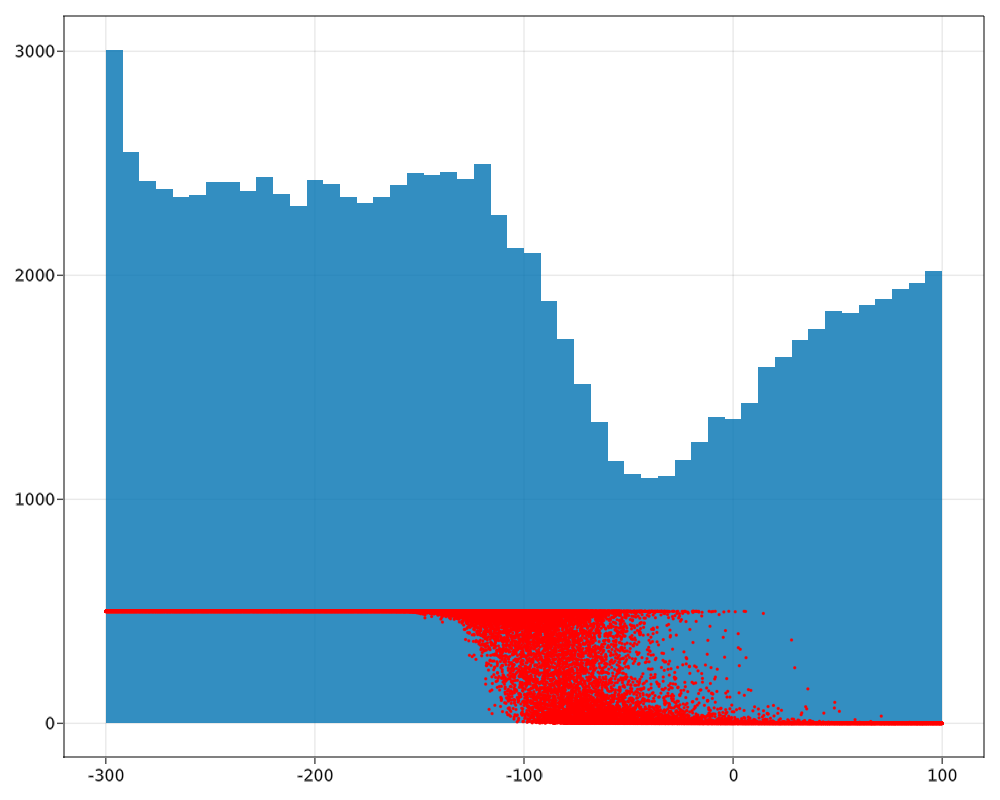

In [67]:
fig = Figure(resolution=(1000,800))

ax = Axis(fig[1,1])
hist!(ax,comt[800].x,bins=50)
scatter!(ax,comt[800].x,comt[800].P.*500,markersize=3,color=:red)

fig

In [9]:
fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1])
x = comt.P
for i in 1:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

ax = Axis(fig[2,1])
x = comt.x
for i in 1:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

fig

LoadError: InterruptException:

### Test 4: Checking tumbling dynamics of motile cells in oscillating gradient Ke environment

In [68]:
model = @agent(2,
    
            theta::Local,
        
            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            absorption::Local,
            tProp::Local,
            [tTumbling,tTumblingMin]::Global,
            KeWidth::Global,
            Ke::Local,          # Difussible medium
            cell::Identity,      # Biofilm cell 1, motile cell tumbling and propelling 2

            UpdateVariable = begin                                   #Equations of the chemical
                VK = VK0+δK*(absorption*Ke+Ki)                       #Resting potential
                VL = VL0+δL*(absorption*Ke+Ki)                       #Resting potential
                d(V) = (-gK*n^4*(V-VK)-gL*(V-VL))/(η*C)*dt           #Membrane potential
                d(n) = (α0*S^mc/(Sth^mc+S^mc)*(1-n)-βc*n)/η*dt       #Potasium levels
                d(S) = (αs*(Vth-V)/(exp((Vth-V)/σ)-1)-γs*S)/η*dt     #Stress
                d(Ki) = (-ϵ*gK*n^4*(V-VK)+βK*max((V0-V),0))*dt       #Intercellular potassium
                d(E) = (-αE*V-γE*E)*dt                               #Energy
        
                d(x) = fProp*cos(theta)*dt
                d(y) = fProp*sin(theta)*dt
            end,
    
            UpdateLocal = begin
                if cell == 2
                    tt = mod(ωPulse*t,2π)
                    if tt >= 0 && tt < π/2
                        Ke = 0
                    elseif tt < 4π/5
                        Ke = 10*αk/3/π*(tt-π/2)*exp(-abs(x-simulationBox[1,2])/KeWidth)
                    elseif tt < 17π/10
                        Ke = αk*10/9/π*(9π/10-(tt-4π/5))*exp(-abs(x-simulationBox[1,2])/KeWidth)
                    else
                        Ke = 0
                    end
                end
        
                #Boundaries to avoid scaping the box
                if x.new < simulationBox[1,1]
                    x = simulationBox[1,1]
                    theta = Uniform(-π/2,π/2) 
                end
                if x.new > simulationBox[1,2]
                    x = simulationBox[1,2]
                    theta = Uniform(π/2,3π/2) 
                end
                if y.new < simulationBox[2,1]
                    y = simulationBox[2,1]
                    theta = Uniform(0,π) 
                end
                if y.new > simulationBox[2,2]
                    y = simulationBox[2,2]
                    theta = Uniform(-π,0) 
                end
        
                P = KE^q/(abs((E-E0))^q+KE^q)  
                if cell == 2 && rand() < dt*(tTumblingMin+tTumbling*(1-P))
                    theta = Uniform(-π,π)
                end
        
            end,
    
)
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");

In [69]:
com = Community(compiled, N = 100000, mediumN = [11,11])

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 10; mA = 1; mS = mA/mV; pg = 1;
com.gK = 36/10E12*μm^2/mS
com.gL = 0.3/10E12*μm^2/mS
com.C = 1*10E-3/10E12*μm^2/mF
com.VK0 = -688/mV
com.VL0 = -5694/mV
com.δK = 1*mM/mV
com.δL = 18*mM/mV
com.Sth = 0.04/mM
com.Vth = -148/mV
com.α0 = 0.12*ms
com.βc = 0.156*ms
com.mc = 1
com.σ = 0.2/mV
com.γs = 0.3*ms
com.αs = 0.03*ms*mV/mM
com.η = 100
com.ϵ = 7000*10E12/3600*mA*ms/mM/μm^2
com.βK = 0.8/3600*ms*mV/mM
com.V0 = -148/mV
com.αE = 0.008/3600*ms*mV
com.γE = 0.8/3600*ms
com.E0 = 1.535/mM
com.q = 7
com.KE = 0.2/mM
com.αk = 37#64/3600*ms/mM*1000
com.βk = 400/3600*ms
com.Dk = 80000/3600*ms/μm^2
com.fProp = 0.005*ms/μm
com.ωPulse = 1/2/216000*2*π*ms*120/200
com.tTumbling = .005*ms
com.tTumblingMin = .0002*ms
com.KeWidth = 80/μm

println(com.global_)

#Local parameters
com.cell .= 2;
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.absorption .= 1

com.simulationBox .= [-300 100;-100 100]
com.radiusInteraction = 1

com.x .= rand(Uniform(com.simulationBox[1,:]...),com.N)
com.y .= rand(Uniform(com.simulationBox[2,:]...),com.N);
com.theta .= rand(Uniform(-π,π),com.N);

[3.6e-12, 3.0e-14, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 1.2, 1.56, 1.0, 0.2, 3.0, 0.3, 100.0, 1.9444444444444444e14, 0.0022222222222222222, -148.0, 2.222222222222222e-5, 0.0022222222222222222, 1.535, 7.0, 0.2, 37.0, 1.1111111111111112, 222.22222222222223, 0.05, 8.726646259971648e-5, 0.05, 0.002, 80.0]


In [70]:
compiled = compile(model,neighbors="full",integrator="Heun",save="RAM",platform="cpu");
@time comt = compiled.evolve(com, tMax = 80000, dt = 1, dtSave = 100);
println("Unstable: ", sum(isnan.(comt.V[end,:])))

2501.388208 seconds (63.79 M allocations: 20.156 GiB, 1.25% gc time, 0.03% compilation time)
Unstable: 0


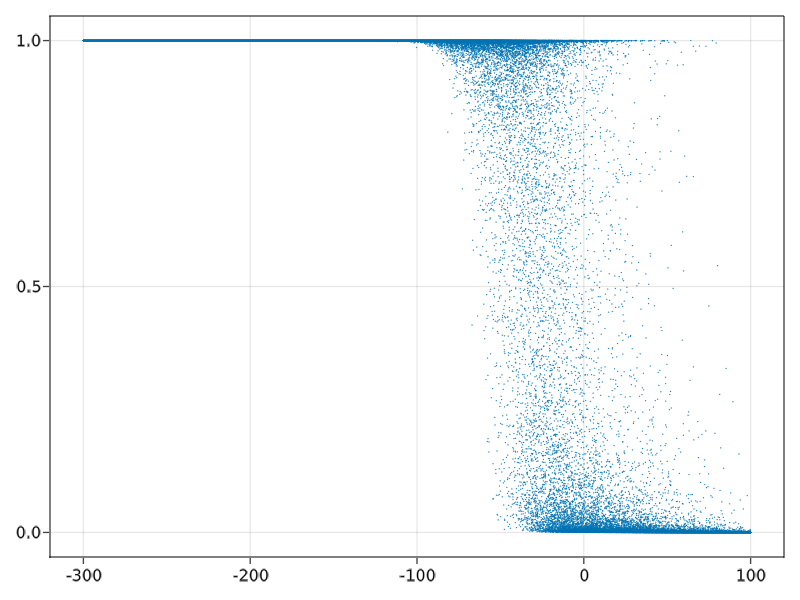

In [71]:
scatter(comt[400].x,comt[400].P,markersize=1)

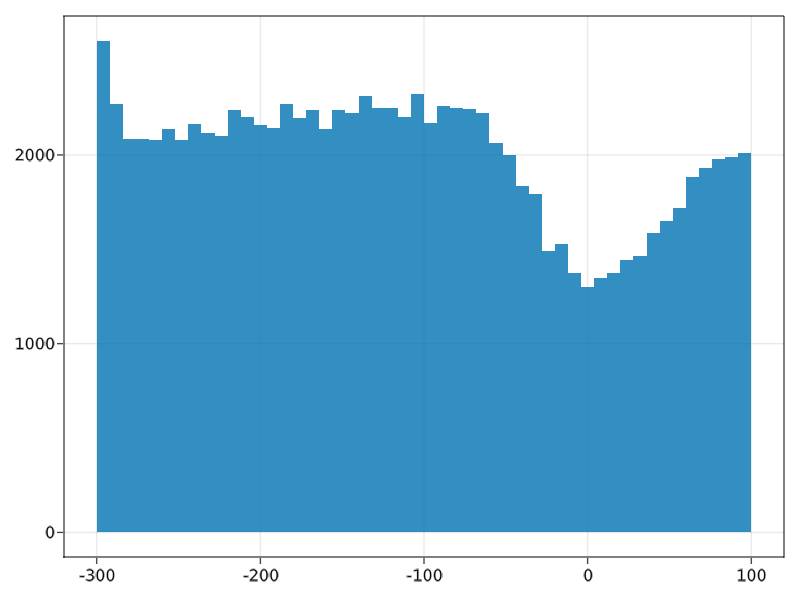

In [72]:
hist(comt[400].x,bins=50)

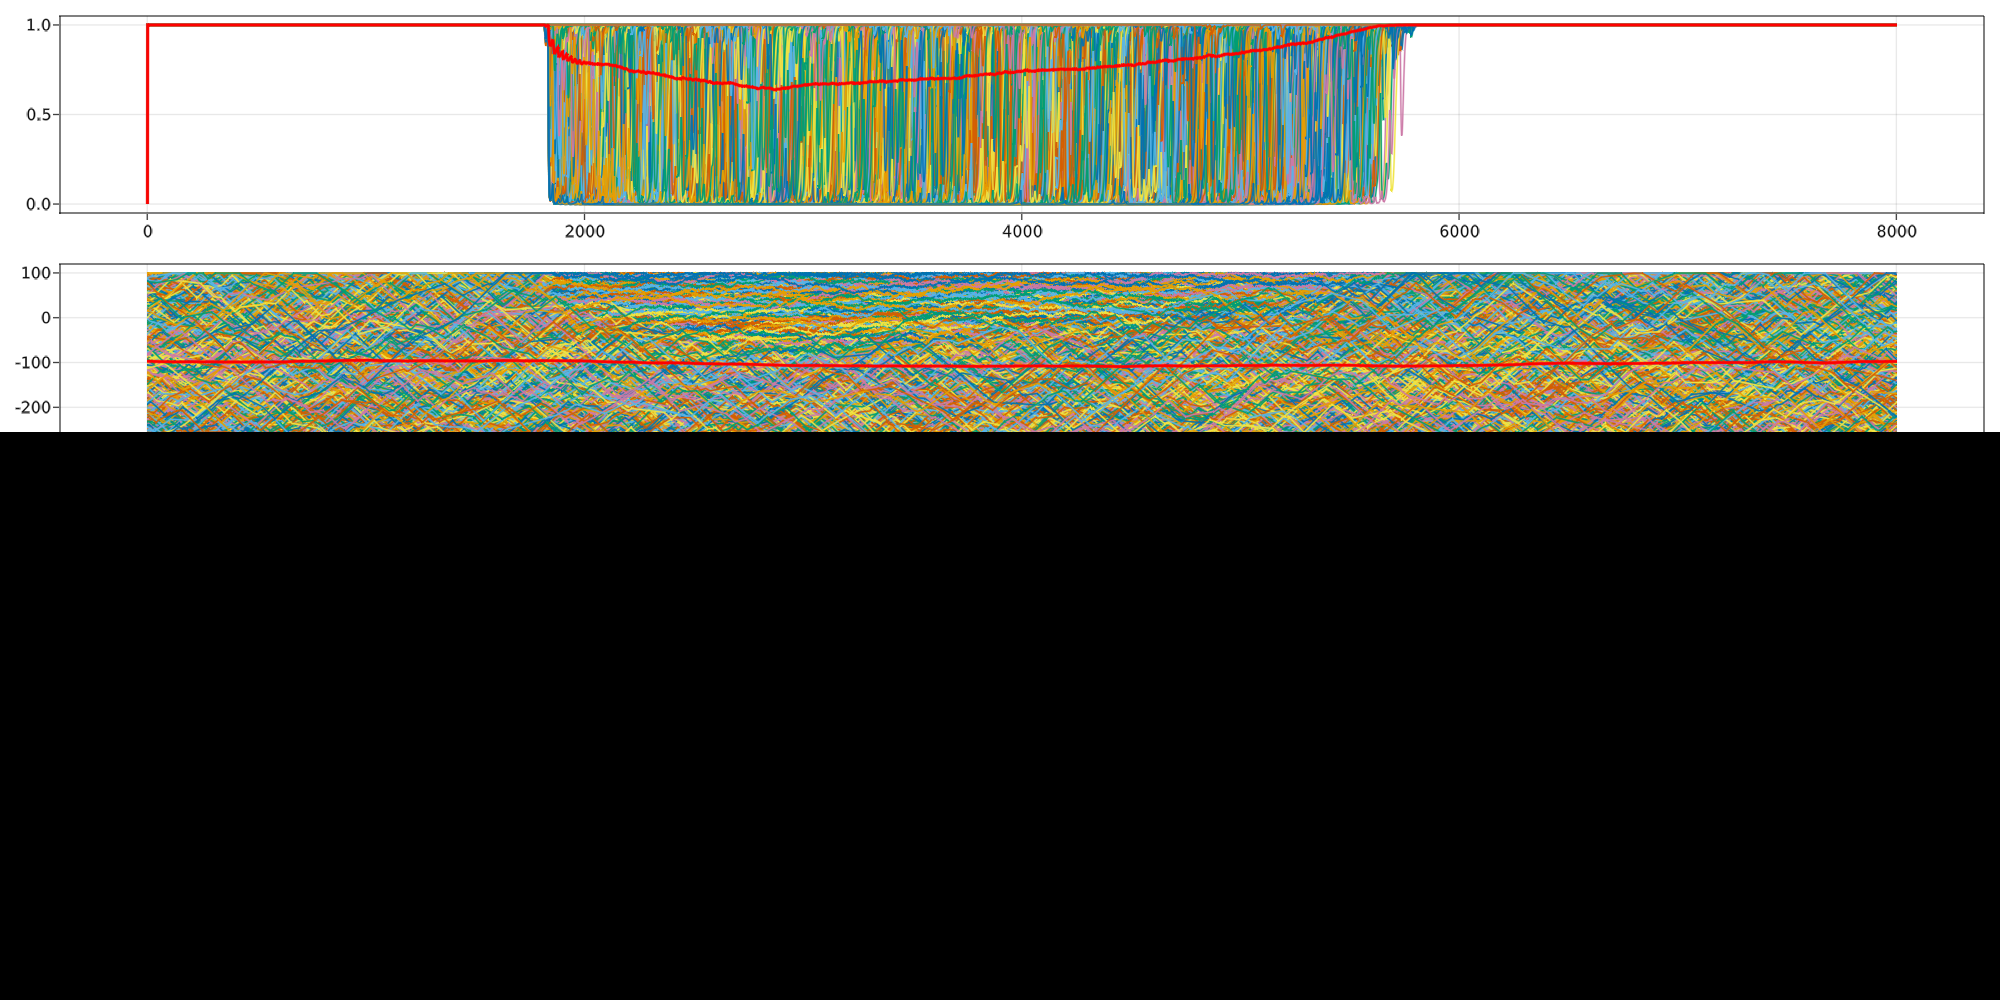

In [5]:
fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1])
x = comt.P
for i in 1:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

ax = Axis(fig[2,1])
x = comt.x
for i in 1:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

ax = Axis(fig[3,1])
x = comt.Ke
for i in 1:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

ax = Axis(fig[4,1])
x = comt.E
for i in 1:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

fig

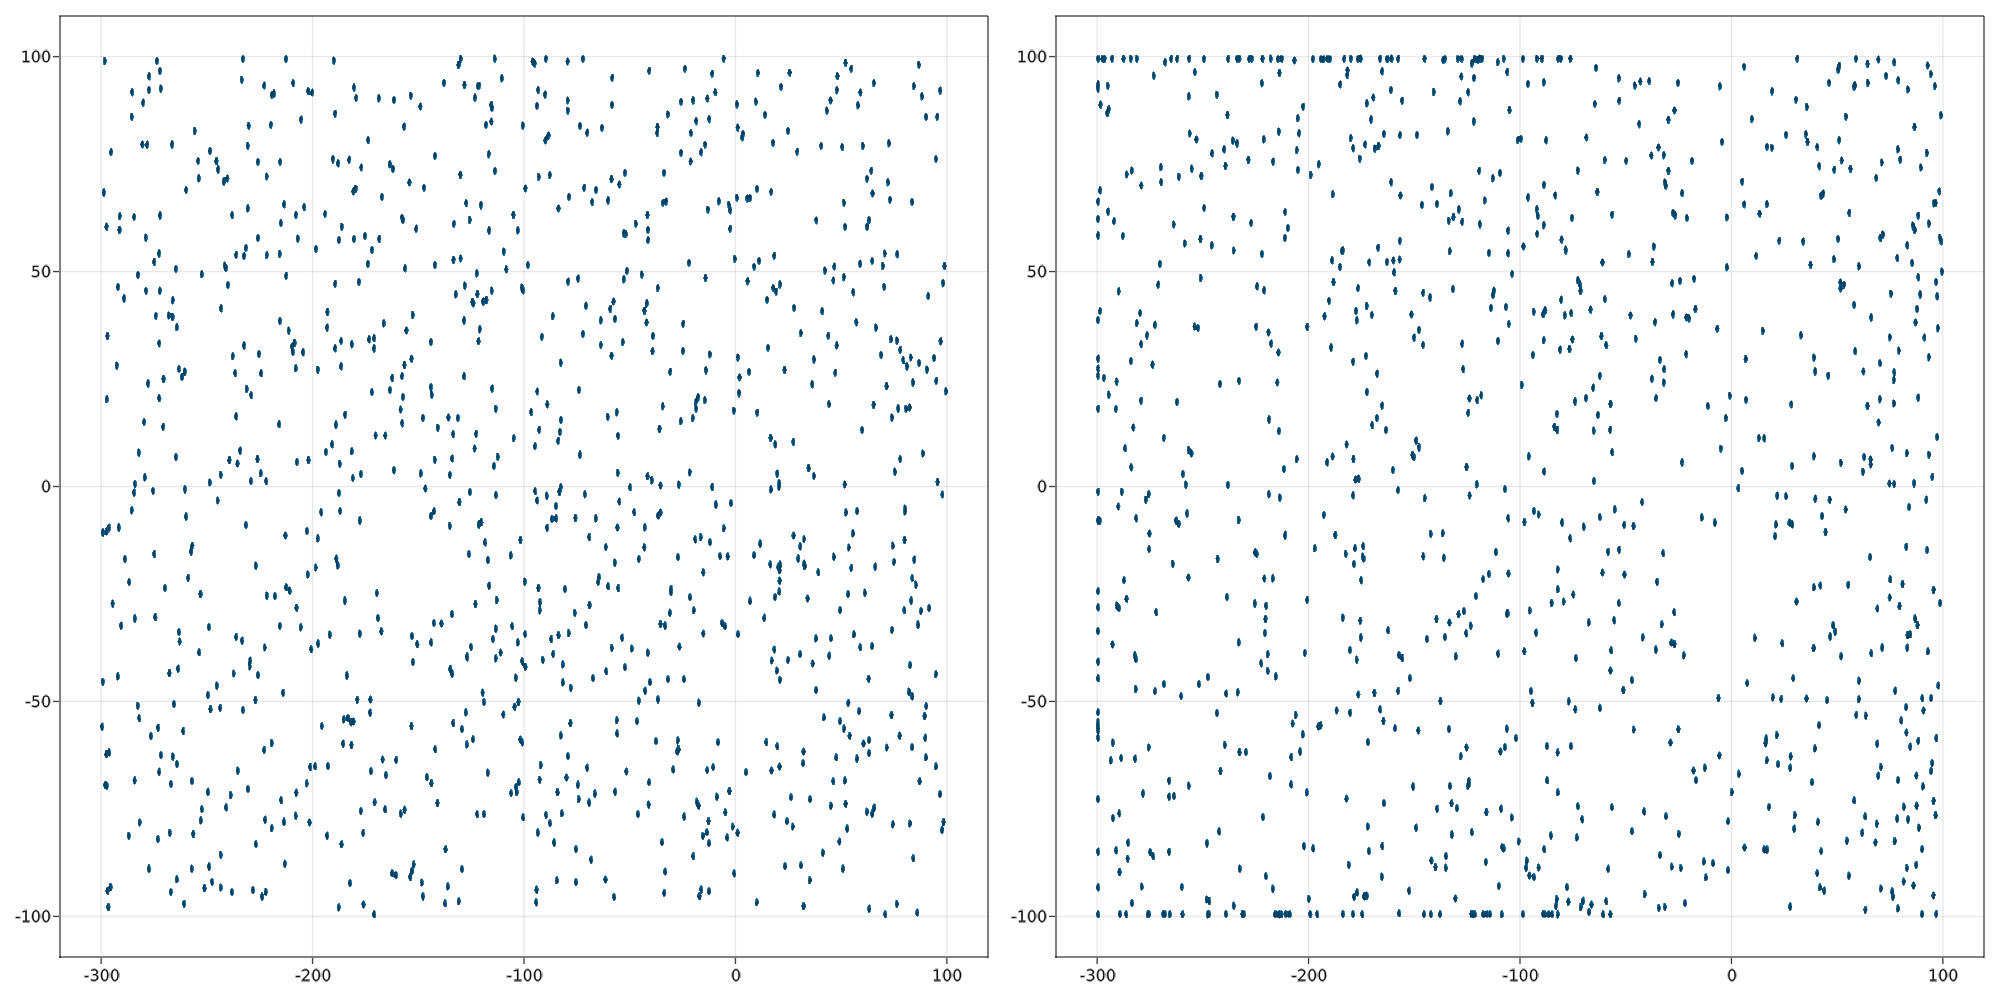

In [7]:
fig = Figure(resolution=(2000,1000))

t = 2
ax = Axis(fig[1,1])
meshscatter!(ax,comt[t].x,comt[t].y,markersize=1)

t = 3000
ax = Axis(fig[1,2])
meshscatter!(ax,comt[t].x,comt[t].y,markersize=1)

fig

## Gradient generation by biofilm cells

### Test 1: Generation of the gradient by biofilm cells

In [274]:
model = @agent(2,
    
            theta::Local,
        
            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            absorption::Local,
            tProp::Local,
            Ke::Medium,          # Difussible medium
            cell::Identity,      # Biofilm cell 1, motile cell tumbling and propelling 2
    
            UpdateMedium = begin 
                ∂t(Ke) = Dk*(Δx(Ke)+Δy(Ke))
        
                NewmannXMax(Ke) = 1
                NewmannXMin(Ke) = 1
                DirichletYMax(Ke) = 0
                DirichletYMin(Ke) = 0
            end,
    
            UpdateLocal = begin
                    if cell == 1
                        tt = mod(ωPulse*t,2π)
                        if tt >= 0 && tt < π/2
                            Ke = 0
                        elseif tt < 4π/5
                            Ke = 10*αk/3/π*(tt-π/2)
                        elseif tt < 17π/10
                            Ke = αk*10/9/π*(9π/10-(tt-4π/5))
                        else
                            Ke = 0
                        end   
                    end
            end,
    
)
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");

In [275]:
40000/2/23/51^2

0.3343195760827775

In [279]:
com = Community(compiled, N = 100, mediumN = [51,51])

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 1; mA = 1; mS = mA/mV;
com.gK = 36/10E12*mS/μm^2
com.gL = 0.3/10E12*mS/μm^2
com.C = 1*10E-3/10E12*mF/μm^2
com.VK0 = -688*mV
com.VL0 = -5694*mV
com.δK = 1*mV/mM
com.δL = 18*mV/mM
com.Sth = 0.04*mM
com.Vth = -148*mV
com.α0 = 0.12/ms
com.βc = 0.156/ms
com.mc = 1
com.σ = 0.2*mV
com.γs = 0.3/ms
com.αs = 0.03*mM/ms/mV
com.η = 300
com.ϵ = 7000*10E12/3600*mM*μm^2/mA/ms
com.βK = 0.8/3600*mM/ms/mV
com.V0 = -148*mV
com.αE = 0.008/3600/ms/mV
com.γE = 0.8/3600/ms
com.E0 = 1.535*mM
com.q = 7
com.KE = 0.002*mM
com.αk = 47#47#64/3600*mM/ms*1000
com.βk = 400/3600/ms
com.Dk = 80000/3600*μm^2/ms
com.fProp = 0.002
com.ωPulse = 1/2/216000*2*π/ms*120/200*100

println(com.global_)

#Local parameters
com.cell .= 1;
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.absorption .= 1

com.simulationBox .= [-200 100;-100 100]
com.radiusInteraction = 1

com.x .= 99.5#com.simulationBox[1,2]-1
com.y .= range(com.simulationBox[2,:]...,length=com.N);

[3.6e-12, 3.0e-14, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 0.12, 0.156, 1.0, 0.2, 0.3, 0.03, 300.0, 1.9444444444444445e13, 0.00022222222222222223, -148.0, 2.222222222222222e-6, 0.00022222222222222223, 1.535, 7.0, 0.002, 47.0, 0.1111111111111111, 22.22222222222222, 0.002, 0.0008726646259971647]


In [280]:
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="gpu");
@time comt = compiled.evolve(com, tMax = 8000, dt = .01, dtSave = 100);

 33.747185 seconds (146.08 M allocations: 8.563 GiB, 3.17% gc time)


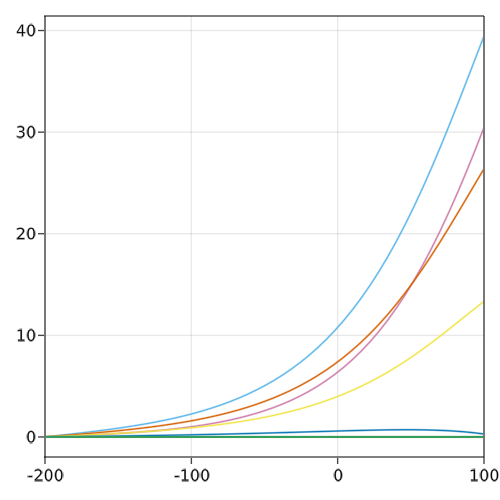

In [282]:
fig = Figure(resolution=(500,500))

ax = Axis(fig[1,1])
for i in Int.(floor.(range(1,length(comt),length=10)))
    lines!(ax,range(com.simulationBox[1,:]...,length=com.mediumN[1]),comt[i].Ke[:,26])
end
xlims!(ax,-200,100)

fig

### Test 2: Combining tumbling cells and biofilm cells

In [139]:
model = @agent(2,
    
            theta::Local,
        
            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            absorption::Local,
            tProp::Local,
            [tTumbling,tTumblingMin]::Global,
            Ke::Medium,          # Difussible medium
            cell::Identity,      # Biofilm cell 1, motile cell tumbling and propelling 2
    
            UpdateVariable = begin                                   #Equations of the chemical
                VK = VK0+δK*(absorption*Ke+Ki)                       #Resting potential
                VL = VL0+δL*(absorption*Ke+Ki)                       #Resting potential
                d(V) = (-gK*n^4*(V-VK)-gL*(V-VL))/(η*C)*dt           #Membrane potential
                d(n) = (α0*S^mc/(Sth^mc+S^mc)*(1-n)-βc*n)/η*dt       #Potasium levels
                d(S) = (αs*(Vth-V)/(exp((Vth-V)/σ)-1)-γs*S)/η*dt     #Stress
                d(Ki) = (-ϵ*gK*n^4*(V-VK)+βK*max((V0-V),0))*dt       #Intercellular potassium
                d(E) = (-αE*V-γE*E)*dt                               #Energy
        
                if cell == 2
                    d(x) = fProp*cos(theta)*dt
                    d(y) = fProp*sin(theta)*dt
                end
            end,
    
            UpdateMedium = begin 
                ∂t(Ke) = Dk*(Δx(Ke)+Δy(Ke))
        
                NewmannXMax(Ke) = 1
                NewmannXMin(Ke) = 1
                DirichletYMax(Ke) = 0
                DirichletYMin(Ke) = 0
            end,
    
            UpdateLocal = begin
                    if cell == 1
                        tt = mod(ωPulse*t,2π)
                        if tt >= 0 && tt < π/2
                            Ke = 0
                        elseif tt < 4π/5
                            Ke = 10*αk/3/π*(tt-π/2)
                        elseif tt < 17π/10
                            Ke = αk*10/9/π*(9π/10-(tt-4π/5))
                        else
                            Ke = 0
                        end   
                    end
        
                #Boundaries to avoid escaping the box
                x = min(simulationBox[1,2]-.5,x.new)
                x = max(simulationBox[1,1]+.5,x.new)
                y = min(simulationBox[2,2]-.5,y.new)
                y = max(simulationBox[2,1]+.5,y.new)
        
                P = KE^q/(abs((E-E0))^q+KE^q)  
                if cell == 2 && Uniform(0,1) < dt*(tTumblingMin+tTumbling*(1-P))
                    theta = Uniform(-π,π)
                end
            end,
    
)
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="cpu");

In [146]:
com = Community(compiled, N = 200, mediumN = [51,51])

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 1; mA = 1; mS = mA/mV;
com.gK = 36/10E12*mS/μm^2
com.gL = 0.3/10E12*mS/μm^2
com.C = 1*10E-3/10E12*mF/μm^2
com.VK0 = -688*mV
com.VL0 = -5694*mV
com.δK = 1*mV/mM
com.δL = 18*mV/mM
com.Sth = 0.04*mM
com.Vth = -148*mV
com.α0 = 0.12/ms
com.βc = 0.156/ms
com.mc = 1
com.σ = 0.2*mV
com.γs = 0.3/ms
com.αs = 0.03*mM/ms/mV
com.η = 300
com.ϵ = 7000*10E12/3600*mM*μm^2/mA/ms
com.βK = 0.8/3600*mM/ms/mV
com.V0 = -148*mV
com.αE = 0.008/3600/ms/mV
com.γE = 0.8/3600/ms
com.E0 = 1.535*mM
com.q = 7
com.KE = 0.002*mM
com.αk = 47#47#64/3600*mM/ms*1000
com.βk = 400/3600/ms
com.Dk = 80000/3600*μm^2/ms/100
com.fProp = 0.002
com.ωPulse = 1/2/216000*2*π/ms*120/200
com.tTumbling = .01
com.tTumblingMin = .0002

println(com.global_)

#Local parameters
com.cell .= [[1 for i in 1:100];[2 for i in 101:com.N]]
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.absorption .= 1

com.simulationBox .= [-100 100;-100 100]
com.radiusInteraction = 1

com.x .= [[99.5 for i in 1:100];rand(Uniform(com.simulationBox[1,:]...),com.N-100)]
com.y .= rand(Uniform(com.simulationBox[2,:]...),com.N);

[3.6e-12, 3.0e-14, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 0.12, 0.156, 1.0, 0.2, 0.3, 0.03, 300.0, 1.9444444444444445e13, 0.00022222222222222223, -148.0, 2.222222222222222e-6, 0.00022222222222222223, 1.535, 7.0, 0.002, 47.0, 0.1111111111111111, 0.2222222222222222, 0.002, 8.726646259971647e-6, 0.01, 0.0002]


In [151]:
compiled = compile(model,neighbors="full",integrator="Euler",save="RAM",platform="gpu");
@time comt = compiled.evolve(com, tMax = 800000, dt = .01, dtSave = 100);

LoadError: InterruptException:

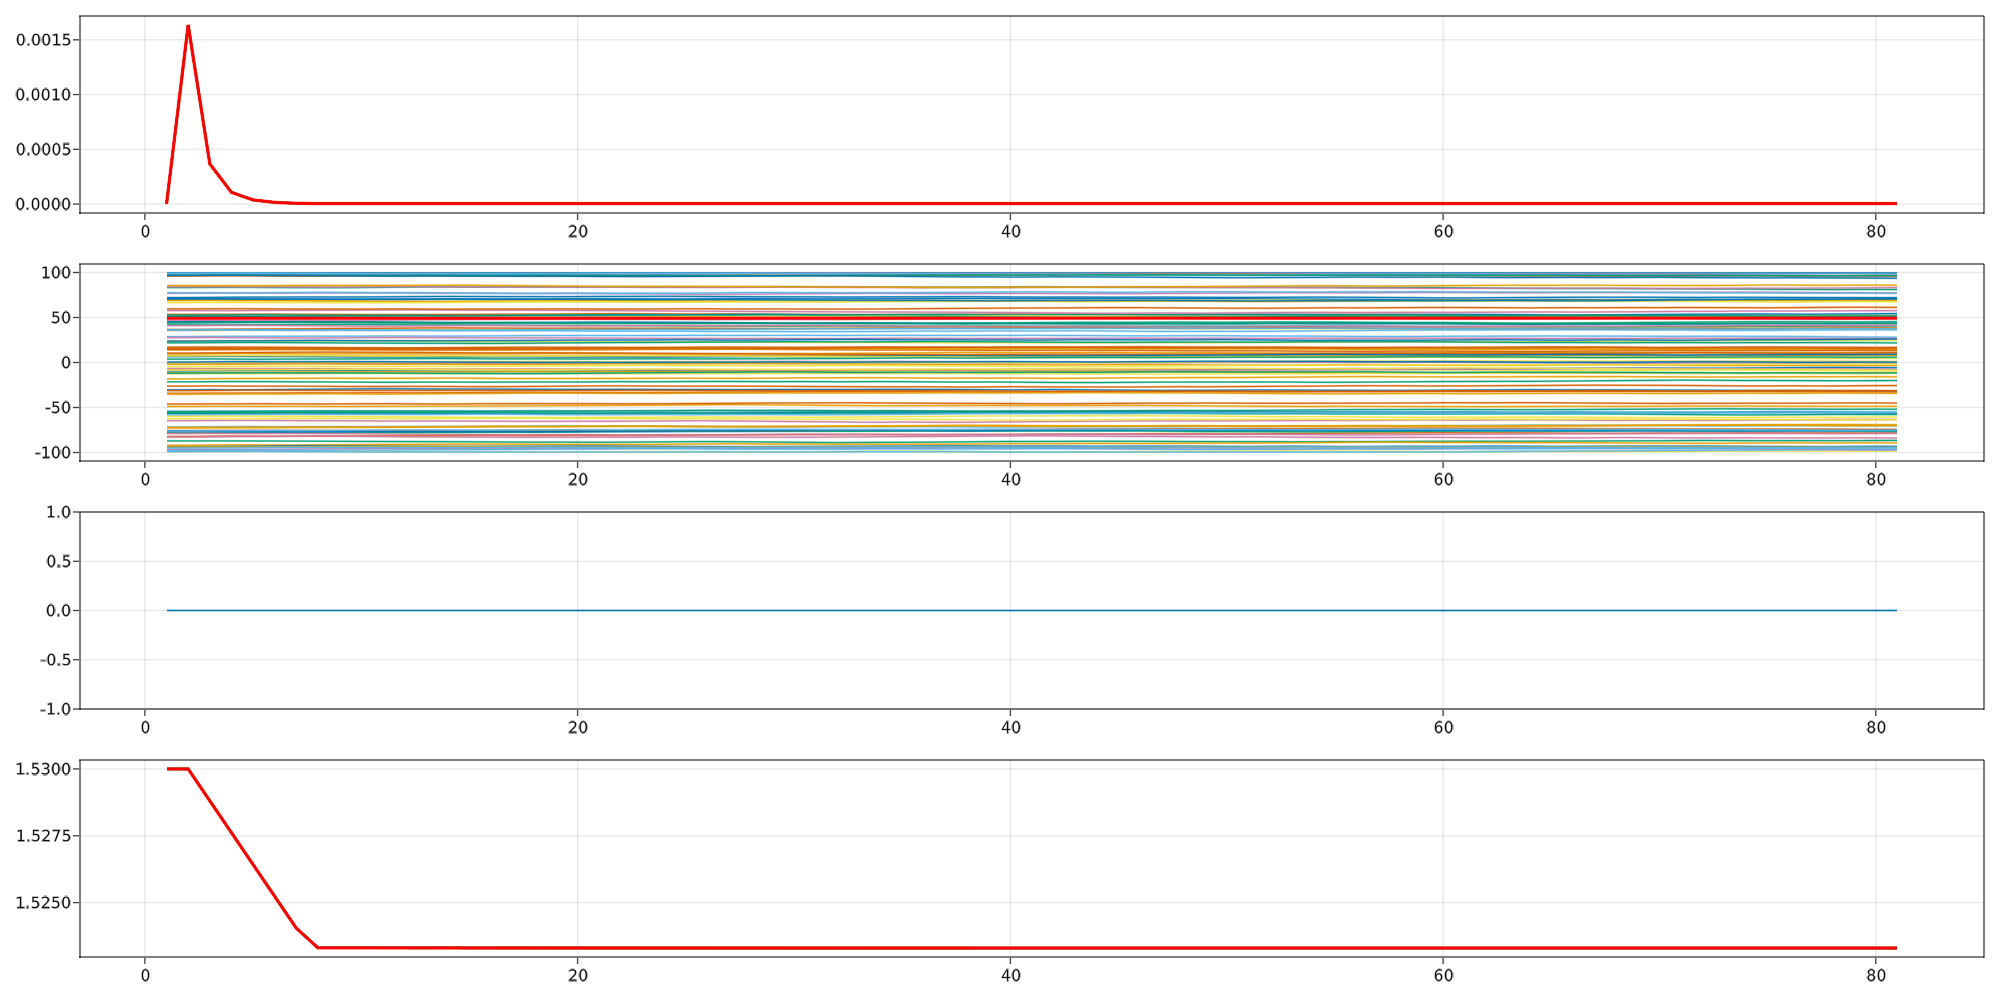

In [150]:
fig = Figure(resolution=(2000,1000))

N = 100

ax = Axis(fig[1,1])
x = comt.P
for i in N:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

ax = Axis(fig[2,1])
x = comt.x
for i in N:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

ax = Axis(fig[3,1])
x = Float64[]
for i in 1:length(comt)
    push!(x,maximum(comt[i].Ke))
end
lines!(ax,1:length(comt),x)

ax = Axis(fig[4,1])
x = comt.E
for i in N:com.N
    lines!(ax,1:length(comt),x[:,i])
end
lines!(ax,1:length(comt),mean(x,dims=2)[:,1],linewidth=3,color=:red)

fig

# Checking active cells dynamics

In [2]:
model = @agent(2,

            UpdateVariable = begin
                if cell == 2
                    fx += fProp*cos(theta)
                    fy += fProp*sin(theta)              
                end
            end,
    
            AgentBasedModels.Models.Bacteria2D::BaseModel,
    
            [gK,gL,C,VK0,VL0,δK,δL,Sth,Vth,α0,βc,mc,σ,γs,αs,η,ϵ,βK,V0,αE,γE,E0,q,KE,αk,βk,Dk,fProp,ωPulse]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Biochemical variables
            [VK,P]::Local,
            tProp::Local,
            [tumblingMin,tumblingMax]::Global,
            Ke::Global,          #Difussible medium
            KeMeasured::Local,
            cell::Identity,      #Biofilm cell 1, motile cell tumbling and propelling 2

            UpdateVariable = begin                                   #Equations of the chemical
                scalar = x/(simulationBox[1,2])
                if scalar < 0
                    scalar = 0
                end
                KeMeasured = scalar^2*Ke
                VK = VK0+δK*(scalar^2*Ke+Ki)                                  #Resting potential
                VL = VL0+δL*(scalar^2*Ke+Ki)                                  #Resting potential
                d(V) = (-gK*n^4*(V-VK)-gL*(V-VL))/(η*C)*dt           #Membrane potential
                d(n) = (α0*S^mc/(Sth^mc+S^mc)*(1-n)-βc*n)/η*dt       #Potasium levels
                d(S) = (αs*(Vth-V)/(exp((Vth-V)/σ)-1)-γs*S)/η*dt     #Stress
                d(Ki) = (-ϵ*gK*n^4*(V-VK)+βK*max((V0-V),0))*dt       #Intercellular potassium
                d(E) = (-αE*V-γE*E)*dt                               #Energy
            end,
    
            UpdateLocal = begin
        
                #Boundaries to avoid scaping the box
                x = min(simulationBox[1,2]-5,x.new)
                x = max(simulationBox[1,1]+5,x.new)
                y = min(simulationBox[2,2]-5,y.new)
                y = max(simulationBox[2,1]+5,y.new)
        
                P = KE^q/((E-E0)^q+KE^q)
                if cell == 2 && tProp < t
                    tProp += (tumblingMax-tumblingMin)*(1-P)+tumblingMin
                    theta = Uniform(0,2π)
                end
        
                #theta = mod(theta.new+2π,2π)
            end,
    
            UpdateGlobal = begin
                if sin(ωPulse*t)>0
                    Ke = αk*mod(t,π/ωPulse)*ωPulse
                else
                    Ke = αk*π-αk*mod(t,π/ωPulse)*ωPulse
                end
            end
    
)
compiled = compile(model,neighbors="grid",integrator="Euler",save="JLD",platform="cpu");

## Check tumbling probability

In [8]:
com = Community(compiled, N = 20, mediumN = [101,101])

#Mechanics model parameters
com.kn = 10^3
com.γn = 2.20
com.γt = 2.00
com.μcc = 0.1
com.β = 100
com.βω = 100.
#com.growth = 0.01
#com.lMax = 4
#com.σLTarget = 1

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 1; mA = 1; mS = mA/mV;
com.gK = 36/10E12*mS/μm^2/10
com.gL = 0.3/10E12*mS/μm^2/10
com.C = 1*10E-3/10E12*mF/μm^2
com.VK0 = -688*mV
com.VL0 = -5694*mV
com.δK = 1*mV/mM
com.δL = 18*mV/mM
com.Sth = 0.04*mM
com.Vth = -148*mV
com.α0 = 0.12/ms
com.βc = 0.156/ms
com.mc = 1
com.σ = 0.2*mV
com.γs = 0.3/ms
com.αs = 0.03*mM/ms/mV*100
com.η = 300
com.ϵ = 7000*10E12/3600*mM*μm^2/mA/ms/10
com.βK = 0.8/3600*mM/ms/mV
com.V0 = -148*mV
com.αE = 0.008/3600/ms/mV/15
com.γE = 0.8/3600/ms/15
com.E0 = 1.535*mM
com.q = 8#7
com.KE = .2#0.002*mM
com.αk = 64/3600*mM/ms*1000*2
com.βk = 400/3600/ms
com.Dk = 80000/3600*μm^2/ms
com.fProp = 0.
com.ωPulse = 1/2/216000*2*π/ms

println(com.global_)

#Simulationbox
com.simulationBox .= [-100 100;-100 100]
com.radiusInteraction = 1

#Local parameters
com.m .= 1.
com.d .= 1.
com.l .= 3.
com.cell .= [[1 for i in 1:10];[2 for i in 11:com.N]];
com.x .= [[99 for i in 1:10];range(0,90,length=com.N-10)]
com.y .= [range(com.simulationBox[2,1]+1,com.simulationBox[2,2]-1,length=10);[0 for i in 1:(com.N-10)]]
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009;

[1000.0, 2.2, 2.0, 0.1, 100.0, 100.0, 3.6e-13, 3.0e-15, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 0.12, 0.156, 1.0, 0.2, 0.3, 3.0, 300.0, 1.9444444444444446e12, 0.00022222222222222223, -148.0, 1.4814814814814815e-7, 1.4814814814814815e-5, 1.535, 8.0, 0.2, 35.55555555555556, 0.1111111111111111, 22.22222222222222, 0.0, 1.4544410433286079e-5, 0.0, 0.0, 0.0]


20-element view(::Matrix{Float64}, :, 12) with eltype Float64:
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009
 0.0009

In [12]:
compiled = compile(model,neighbors="grid",integrator="Euler",save="RAM",platform="cpu");
comt = compiled.evolve(com, tMax = 800000, dt = 1, dtSave = 10);

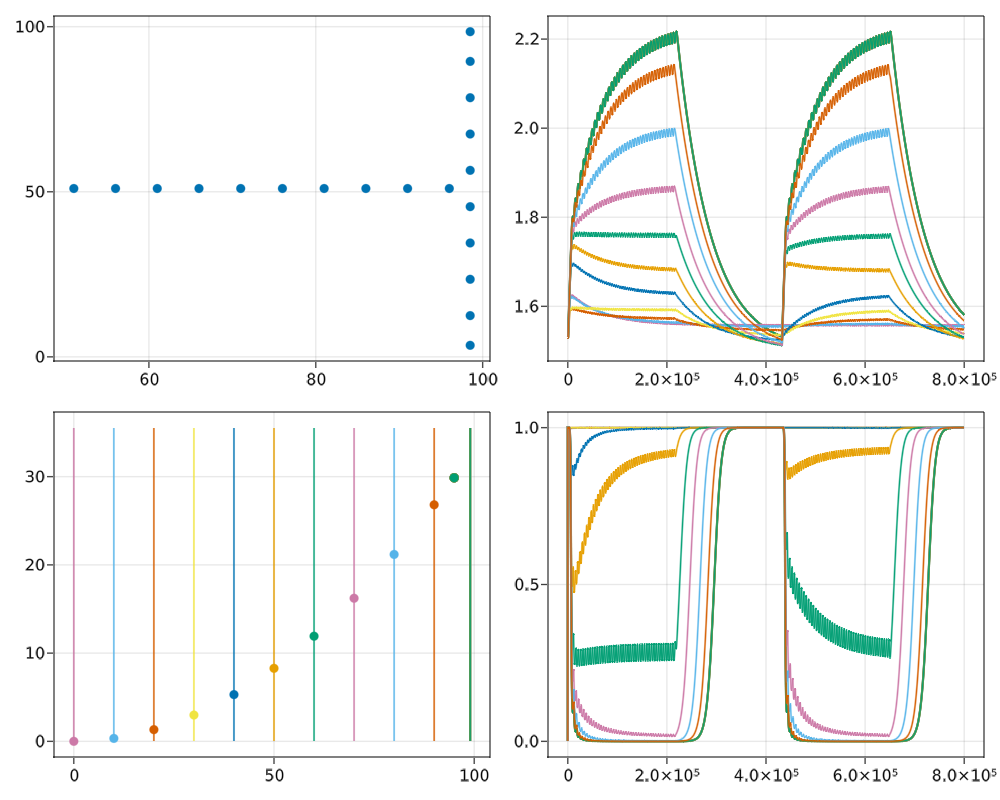

In [13]:
fig = Figure(resolution=(1000,800)) 

N=80000

ax=Axis(fig[1,1])
scatter!(comt[end].x .*.5 .+51,comt[end].y .*.5 .+51)
#heatmap!(ax,comt[N].Ke,xmin=-10)
#xlims!(ax,-10,10)
#ylims!(ax,-10,10)

ax=Axis(fig[1,2])
for i in 1:com.N
    lines!(ax,comt.t,comt.E[:,i])
end

ax=Axis(fig[2,1])
for i in 1:com.N
    scatter!(ax,comt.x[end,i:i],comt.KeMeasured[end,i:i])
    lines!(ax,com.x[i].*ones(2),range(0,com.αk,length=2))
end

ax=Axis(fig[2,2])
for i in 1:com.N
    lines!(ax,comt.t,comt.P[:,i])
end

fig

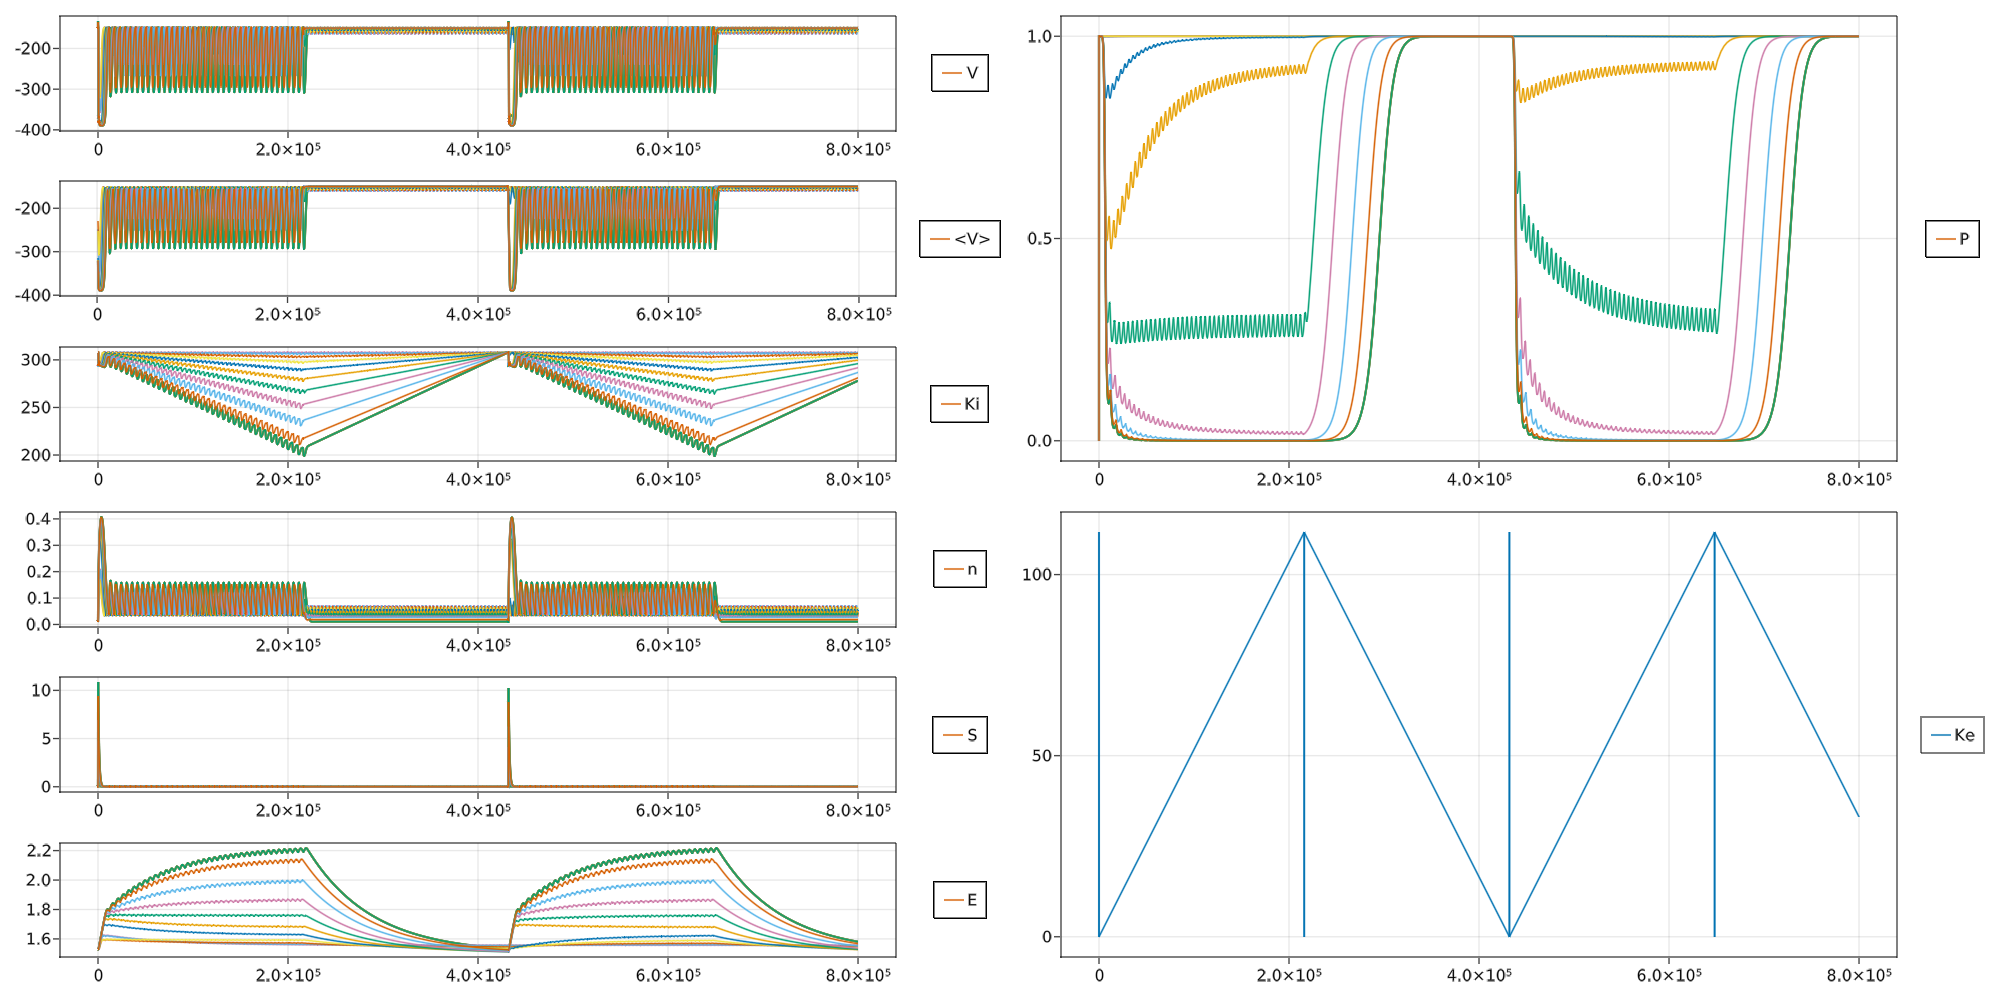

In [14]:
N0 = 1
N = 80000

fig = Figure(resolution=(2000,1000))

ax = Axis(fig[1,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.V[N0:N,i])
    Legend(fig[1,2],[l],["V"])
end
#ylims!(ax,(-300,-140))

ax = Axis(fig[2,1])
av = 100
V = comt.V
for i in 1:com.N
    Vmean = [mean(V[j-av:j+av,i]) for j in N0+av:N-av]
    l = lines!(comt.t[N0+av:N-av],Vmean)
    Legend(fig[2,2],[l],["<V>"])
end

ax = Axis(fig[3,1])
for i in 1:com.N
    l = lines!(comt.t[N0:N],comt.Ki[N0:N,i])
    Legend(fig[3,2],[l],["Ki"])
end

ax = Axis(fig[4,1])
for i in 1:com.N
    l = lines!(comt.t[N0:N],comt.n[N0:N,i])
    Legend(fig[4,2],[l],["n"])
end

ax = Axis(fig[5,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.S[N0:N,i])
    Legend(fig[5,2],[l],["S"])
end

ax = Axis(fig[6,1])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.E[N0:N,i])
    Legend(fig[6,2],[l],["E"])
end

ax = Axis(fig[1:3,3])
for i in 1:com.N
    l = lines!(ax,comt.t[N0:N],comt.P[N0:N,i],label="P")
    Legend(fig[1:3,4],[l],["P"])
end

ax = Axis(fig[4:6,3])
l = lines!(ax,comt.t[N0:N],[comt[i].Ke[end] for i in N0:N],label="Ke")
Legend(fig[4:6,4],[l],["Ke"])

fig

## Check motile population concentrating

In [15]:
com = Community(compiled, N = 1000, mediumN = [101,101])

#Mechanics model parameters
com.kn = 10^3
com.γn = 2.20
com.γt = 2.00
com.μcc = 0.1
com.β = 100
com.βω = 100.
#com.growth = 0.01
#com.lMax = 4
#com.σLTarget = 1

#Biochemical parameters
#UNITS: mS, μm, mF, mV, mM, ms, mA
μm = 1; mF = 1; mV = 1; mM = 1; ms = 1; mA = 1; mS = mA/mV;
com.gK = 36/10E12*mS/μm^2/10
com.gL = 0.3/10E12*mS/μm^2/10
com.C = 1*10E-3/10E12*mF/μm^2
com.VK0 = -688*mV
com.VL0 = -5694*mV
com.δK = 1*mV/mM
com.δL = 18*mV/mM
com.Sth = 0.04*mM
com.Vth = -148*mV
com.α0 = 0.12/ms
com.βc = 0.156/ms
com.mc = 1
com.σ = 0.2*mV
com.γs = 0.3/ms
com.αs = 0.03*mM/ms/mV*100
com.η = 300
com.ϵ = 7000*10E12/3600*mM*μm^2/mA/ms/10
com.βK = 0.8/3600*mM/ms/mV
com.V0 = -148*mV
com.αE = 0.008/3600/ms/mV/15
com.γE = 0.8/3600/ms/15
com.E0 = 1.535*mM
com.q = 8#7
com.KE = .2#0.002*mM
com.αk = 64/3600*mM/ms*1000
com.βk = 400/3600/ms
com.Dk = 80000/3600*μm^2/ms
com.fProp = 1
com.ωPulse = 1/2/216000*2*π/ms

println(com.global_)

#Simulationbox
com.simulationBox .= [-200 200;-100 100]
com.radiusInteraction = 5

#Local parameters
com.m .= 1.
com.d .= 1.
com.l .= 3.
com.cell .= 1;
com.V .= -149.70
com.n .= 0.013
com.Ki .= 308.02
com.VK .= -379.98
com.E .= 1.53
com.S .= 0.0009
com.cell .= [2 for i in 1:com.N];
com.x .= rand(Uniform(com.simulationBox[1,1],com.simulationBox[1,2]),com.N)
com.y .= rand(Uniform(com.simulationBox[2,1],com.simulationBox[2,2]),com.N)
com.theta .= rand(Uniform(0,2π),com.N)

#Constants motion
com.tumblingMin = 1000
com.tumblingMax = 1000/30

[1000.0, 2.2, 2.0, 0.1, 100.0, 100.0, 3.6e-13, 3.0e-15, 1.0e-15, -688.0, -5694.0, 1.0, 18.0, 0.04, -148.0, 0.12, 0.156, 1.0, 0.2, 0.3, 3.0, 300.0, 1.9444444444444446e12, 0.00022222222222222223, -148.0, 1.4814814814814815e-7, 1.4814814814814815e-5, 1.535, 8.0, 0.2, 17.77777777777778, 0.1111111111111111, 22.22222222222222, 1.0, 1.4544410433286079e-5, 0.0, 0.0, 0.0]


33.333333333333336

In [17]:
compiled = compile(model,neighbors="grid",integrator="Euler",save="RAM",platform="cpu");
@btime comt = compiled.evolve(com, tMax = 800, dt = .01, dtSave = 1, saveFile = "Simulation1");

  43.471 s (4829868 allocations: 2.70 GiB)


In [18]:
compiled = compile(model,neighbors="grid",integrator="Euler",save="RAM",platform="gpu");
@btime comt = compiled.evolve(com, tMax = 800, dt = .01, dtSave = 1, saveFile = "Simulation1");

  37.160 s (101307134 allocations: 9.82 GiB)


In [ ]:
JLD.load("Simulation1.jld")

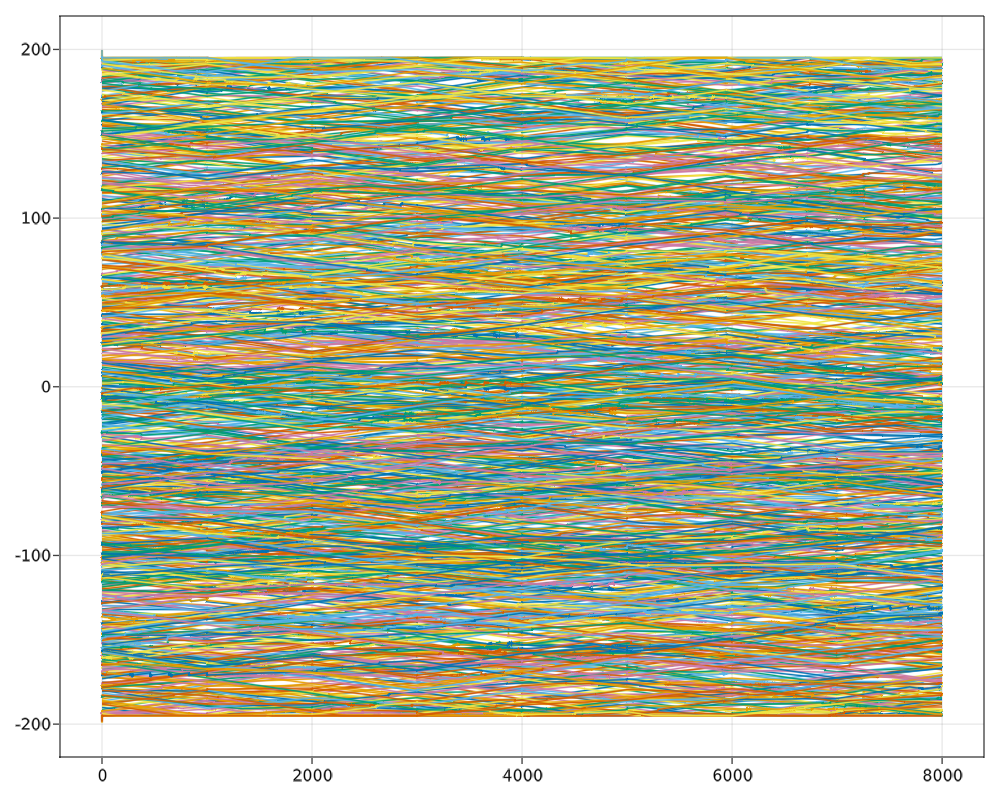

In [12]:
fig = Figure(resolution=(1000,800)) 

ax = Axis(fig[1,1])
x = comt.x
for i in 1:com.N
    lines!(ax,comt.t,x[:,i])
end

fig

In [ ]:
fig = Figure(resolution=(1000,800)) 

ax=Axis(fig[1,1])
x = comt.x
y = comt.y
for i in 1:com.N
    lines!(x[:,i],y[:,i])
end
scatter!(x[end,:],y[end,:])

fig